In [1]:
import pandas as pd
from glob import glob
import json
from NumpyEncoder import NumpyEncoder
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns 

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import scipy.stats as stats
from scipy.special import gamma
from scipy import optimize
from scipy.stats import linregress


In [3]:
import xarray as xr

In [4]:
from scipy.interpolate import interp2d

In [5]:
import tensorflow as tf
import tensorflow.compat.v1 as tf

In [6]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
#matplotlib notebook
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams['figure.figsize'] = (12, 8)
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
plt.rcParams['text.usetex'] = False
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [8]:
palette=sns.color_palette(as_cmap=1)

In [9]:
palette

['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']

In [10]:
def df2latex(df,Nd=3):
    print(df.to_latex(float_format="%0.{}f".format(Nd)))

###  Relu

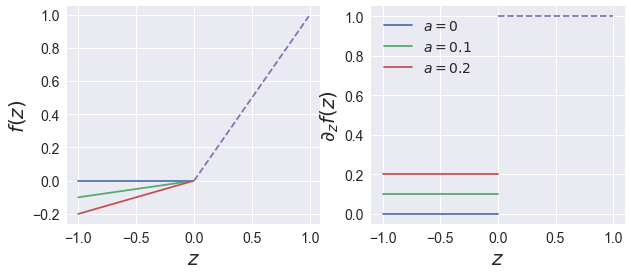

In [16]:
fig, ax = plt.subplots(1,2,figsize=[10,4])
x=np.arange(-1,0,0.01)
relu= lambda x,a : np.max([a*x,x])
y1=np.asarray([relu(xx,0) for xx in x])
y2=np.asarray([relu(xx,0.1) for xx in x])
y3=np.asarray([relu(xx,0.2) for xx in x])
ax[0].plot(x,0*x)
ax[0].plot(x,0.1*x)
ax[0].plot(x,0.2*x)
x2=np.arange(0,1,0.01)
ax[0].plot(x2,x2,"--")
ax[1].plot([-1,0],[0,0],label=r"$a=0$")
ax[1].plot([-1,0],[0.1,0.1],label=r"$a=0.1$")
ax[1].plot([-1,0],[0.2,0.2],label=r"$a=0.2$")
ax[1].plot([0,1],[1,1],'--')
ax[0].set_ylabel(r"$f(z)$")
ax[1].set_ylabel(r"$\partial_z f(z)$")
ax[1].set_xlabel(r"$z$")
ax[0].set_xlabel(r"$z$")
plt.legend()


###  example fields

In [12]:
def get_tick_loc(ticks,coord):
    loc=[]
    for tick in ticks:
        if tick<=0:
            loc+=[np.argmin(np.abs(coord+np.abs(tick)))]
        else:
            loc+=[np.argmin(np.abs(coord-tick))]

    return loc

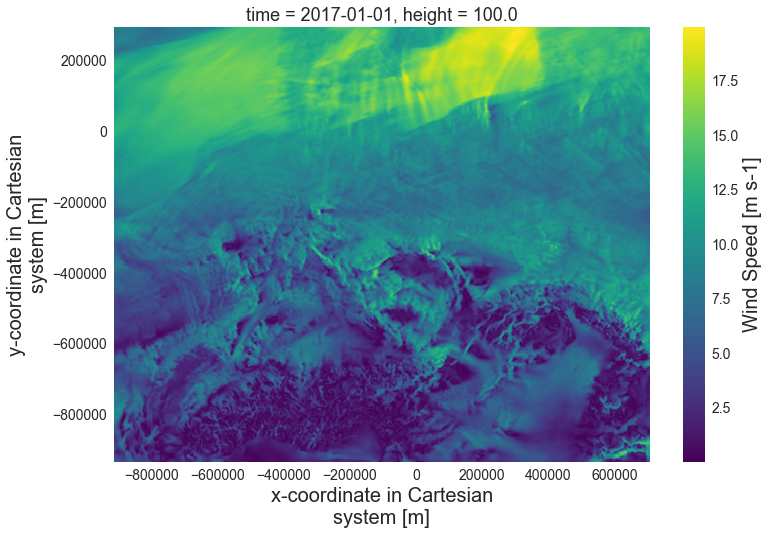

In [14]:
ncfile='//smb.uni-oldenburg.de/hpc_data/thesis/data/ncfiles\\P-CE-2017-2017-01-01.nc'
dom="CE"
ds=xr.open_dataset(ncfile)
if dom=="CE":
    ds=ds.isel(south_north=slice(2,412))
else:
    ds=ds.isel(west_east=slice(3,393))
ds=ds.isel(height=2,time=0)
LR=ds.WS.coarsen(south_north=10,west_east=10).mean()
grid={}#init
grid["sn_lr"]=LR.south_north.values
grid["we_lr"]=LR.west_east.values
grid["sn"]=ds.south_north.values
grid["we"]=ds.west_east.values

grid_CE=grid

ds.WS.plot()
xticks,_=plt.xticks()
yticks,_=plt.yticks()

CE_y=grid_CE["sn"]
CE_x=grid_CE["we"]

xticks_loc_CE=get_tick_loc(xticks[1:-1],CE_x)
yticks_loc_CE=get_tick_loc(yticks[1:-1],CE_y)
plot_yticks_CE=[int(tick/1e3) for tick in yticks[1:-1]]
plot_xticks_CE=[int(tick/1e3) for tick in xticks[1:-1]]
ds.close()

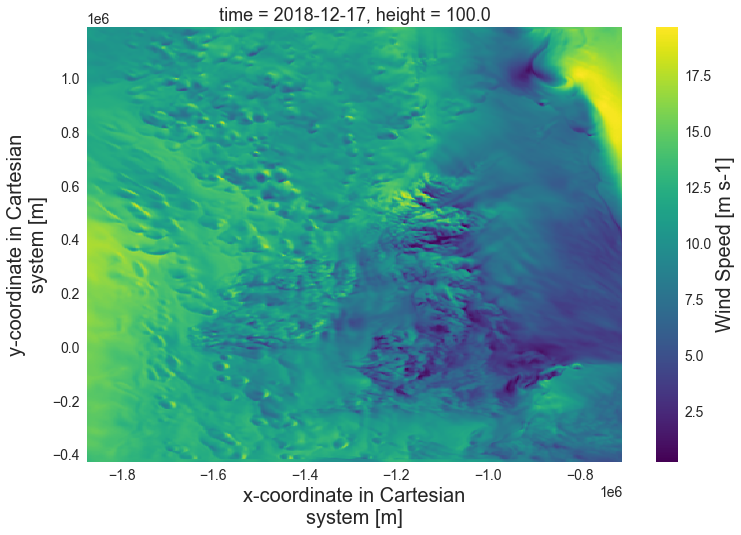

In [13]:
ncfile='//smb.uni-oldenburg.de/hpc_data/NEWA_nc\\P-GB-2018-2018-12-17.nc'
dom="GB"
ds=xr.open_dataset(ncfile)
if dom=="CE":
    ds=ds.isel(south_north=slice(2,412))
else:
    ds=ds.isel(west_east=slice(3,393))
ds=ds.isel(height=2,time=0)
LR=ds.WS.coarsen(south_north=10,west_east=10).mean()
grid={}#init
grid["sn_lr"]=LR.south_north.values
grid["we_lr"]=LR.west_east.values
grid["sn"]=ds.south_north.values
grid["we"]=ds.west_east.values

grid_GB=grid

ds.WS.plot()
xticks,_=plt.xticks()
yticks,_=plt.yticks()

GB_y=grid_GB["sn"]
GB_x=grid_GB["we"]

xticks_loc_GB=get_tick_loc(xticks[1:-1],GB_x)
yticks_loc_GB=get_tick_loc(yticks[1:-1],GB_y)
plot_yticks_GB=[int(tick/1e3) for tick in yticks[1:-1]]
plot_xticks_GB=[int(tick/1e3) for tick in xticks[1:-1]]

ds.close()

In [47]:
def downscale_image(x, K):
    tf.reset_default_graph()

    if x.ndim == 3:
        x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))

    x_in = tf.placeholder(tf.float64, [None, x.shape[1], x.shape[2], x.shape[3]])
    weight = tf.constant(1.0/K**2, shape=[K, K, x.shape[3], 1], dtype=tf.float64)
    p_filt=tf.eye(2,batch_shape=[1,1],  dtype=tf.float64)
    downscaled = tf.nn.separable_conv2d(x_in,depthwise_filter=weight,pointwise_filter=p_filt, strides=[1, K, K, 1], padding='SAME')
    with tf.Session() as sess:
        ds_out = sess.run(downscaled, feed_dict={x_in: x})
    return ds_out

In [48]:
def get_plot_limits2(d,keys):
    vmin0,vmax0=1,0
    vmin1,vmax1=1,0
    for key in d.keys():
        vmin0_key, vmax0_key = np.percentile(np.asarray(d[key])[:,:],1), np.percentile(np.asarray(d[key]["MD"])[:,:],99)
        vmin1_key, vmax1_key = np.min(0.5*(1-np.asarray(d[key]["CD"])[:,:])), np.percentile(0.5*(1-np.asarray(d[key]["CD"])[:,:]),99)

        if vmin0_key <vmin0:
            vmin0=vmin0_key
        if vmin1_key <vmin1:
            vmin1=vmin1_key
        if vmax0_key >vmax0:
            vmax0=vmax0_key
        if vmax1_key >vmax1:
            vmax1=vmax1_key
    return  vmin0,vmax0,vmin1,vmax1

In [49]:
def get_bicubic_interp_SR(LR_val,grid):


    SR_all=None
    for i in range(np.shape(LR_val)[0]):
        fu=interp2d(grid["we_lr"],grid["sn_lr"],LR_val[i,:,:,0],kind="cubic")
        fv=interp2d(grid["we_lr"],grid["sn_lr"],LR_val[i,:,:,1],kind="cubic")
        zu = fu(grid["we"], grid["sn"])
        zv = fv(grid["we"], grid["sn"])

        SR=np.stack([zu,zv],axis=-1)
        SR=SR[np.newaxis,...]
        if SR_all is None:
            SR_all=SR
        else:
            SR_all=np.concatenate([SR_all,SR],axis=0)
    return SR_all

In [50]:
def get_plot_examples(p0="//smb.uni-oldenburg.de/hpc_data/thesis/data",file="P-CE-2006-2007-01-01_dataSR.npy",models=None,labs=None,dom="CE"):
    target_file="/".join([p0,"test",dom,"final",file[10:14],file.replace("_dataSR","")])
    target=np.load(target_file)
    LR=downscale_image(target,10)
    (N,H0,W0,C)=np.shape(target)
    
    d={} #init plot data
    d["HR"]=target
    d["LR"]=LR
    for i,model in enumerate(models):
        if model=="Bicubic":
            if dom=="CE":
                d["Bicubic"]=get_bicubic_interp_SR(LR,grid_CE)
                print("baseline done")
            elif dom=="GB":
                d["Bicubic"]=get_bicubic_interp_SR(LR,grid_GB)
                print("baseline done")
                
        else:
            print(model)
            d[labs[i]]=np.load("/".join([p0,"out",model,file]))
        
    return d
            
    
            

In [51]:
def plot_SR_HR_data(d, path,keys=None,size=[10,6],
                    xticks_loc=[],plot_xticks=[],
                    yticks_loc=[],plot_yticks=[]):
    if keys is None:
        keys=list(d.keys())

    HR=d["HR"]
    try:
        keys.remove('HR')
    except:
        print("No HR")
        
    if "LR" in keys:
        LR=d["LR"]
        keys.remove('LR')
    else:
        LR=downscale_image(HR,10)

    Ncol=len(keys)+2
    for i in range(HR.shape[0]):
        #plt.figure(figsize=(16, 8))
        fig, ax = plt.subplots(2, Ncol,figsize=size,gridspec_kw = {'wspace':0.05, 'hspace':0.05, "top":0.95,"bottom":0.02})
        #plotting limits based on HR data
        vmin0, vmax0 = np.min(HR[i,:,:,0]), np.max(HR[i,:,:,0])
        vmin1, vmax1 = np.min(HR[i,:,:,1]), np.max(HR[i,:,:,1])

        # HR rightmost plot
        ax_=ax[0,-1]
        ax_.imshow(HR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
        ax_.set_title('Ground truth')

        #plt.colorbar()
        ax_.set_xticks([])
        ax_.set_yticks([])

        #plt.tight_layout()

        ax_=ax[1,-1]
        ax_.imshow(HR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')

        #plt.colorbar()
        #x_.set_xticks([])
        ax_.set_yticks([])
        ax_.set_xticks(xticks_loc)
        ax_.set_xticklabels(plot_xticks)
        ax_.grid()
        #plt.tight_layout()

        # LR leftmost plot
        ax_=ax[0,0]
        ax_.imshow(LR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
        ax_.set_title('LR input')
        ax_.set_ylabel('u')
        ax_.set_xticks([])
        #ax_.set_yticks([])
        #plt.tight_layout()
        ax_.set_yticks([loc/10 for loc in yticks_loc])
        ax_.set_yticklabels(plot_yticks)
        ax_.grid()


        ax_=ax[1,0]
        ax_.imshow(LR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
        #plt.colorbar()
        ax_.set_ylabel('v')
        #ax_.set_xticks([])
        #ax_.set_yticks([])
        #plt.tight_layout()
        ax_.set_yticks([loc/10 for loc in yticks_loc])
        ax_.set_yticklabels(plot_yticks)
        ax_.set_xticks([loc/10 for loc in xticks_loc])
        ax_.set_xticklabels(plot_xticks)
        ax_.grid()

        # loop through comparison models
        for j,key in enumerate(keys):
            SR=d[key]

            ax_=ax[0,j+1]
            im0=ax_.imshow(SR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
            ax_.set_title(key)
            #plt.colorbar()
            ax_.set_xticks([])
            ax_.set_yticks([])
            #plt.tight_layout()

            ax_=ax[1,j+1]
            im1=ax_.imshow(SR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
            #plt.colorbar()
            #ax_.set_xticks([])
            ax_.set_xticks(xticks_loc)
            ax_.set_xticklabels(plot_xticks)
            ax_.grid()
            ax_.set_yticks([])
            #plt.tight_layout()
        #plt.tight_layout()
        #fig.tight_layout()
        #fig.subplots_adjust(right=0.8)
        fig.subplots_adjust(right=0.95)
        cbar_ax0 = fig.add_axes([0.96, 0.52, 0.03, 0.4])
        cbar=fig.colorbar(im0, cax=cbar_ax0)
        cbar.set_label("m/s") 
        cbar_ax1 = fig.add_axes([0.96, 0.05, 0.03, 0.4])
        cbar=fig.colorbar(im1, cax=cbar_ax1)
        cbar.set_label("m/s") 
        plt.savefig(path+'_HRvsSRimg{0:05d}.png'.format(i), dpi=200, bbox_inches='tight')
        plt.savefig(path+'_HRvsSRimg{0:05d}.eps'.format(i), format='eps', bbox_inches='tight')
        plt.close()

In [52]:
def plot_SR_HR_data_vert(d, path,keys=None,size=[10,6],
                         xticks_loc=[],plot_xticks=[],
                         yticks_loc=[],plot_yticks=[]):
    if keys is None:
        keys=list(d.keys())

    HR=d["HR"]
    try:
        keys.remove('HR')
    except:
        print("No HR")
        
    if "LR" in keys:
        LR=d["LR"]
        keys.remove('LR')
    else:
        LR=downscale_image(HR,10)

    Nrow=len(keys)+2
    for i in range(HR.shape[0]):
        #plt.figure(figsize=(16, 8))
        fig, ax = plt.subplots(Nrow, 2,figsize=size,gridspec_kw = {'wspace':0.05, 'hspace':0.05, "top":0.99,"bottom":0.05})
        #plotting limits based on HR data
        vmin0, vmax0 = np.min(HR[i,:,:,0]), np.max(HR[i,:,:,0])
        vmin1, vmax1 = np.min(HR[i,:,:,1]), np.max(HR[i,:,:,1])

        # HR bottom plot
        ax_=ax[-1,0]
        ax_.imshow(HR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
        ax_.set_ylabel('Ground truth')
        #ax_.set_title('u')
        #plt.colorbar()
        #ax_.set_xticks([])
        ax_.set_yticks(yticks_loc)
        ax_.set_yticklabels(plot_yticks)
        ax_.set_xticks(xticks_loc)
        ax_.set_xticklabels(plot_xticks)
        ax_.grid()

        #plt.tight_layout()

        ax_=ax[-1,1]
        ax_.imshow(HR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
        #ax_.set_title('v')
        #plt.colorbar()
        #ax_.set_xticks([])
        ax_.set_yticks([])
        #plt.tight_layout()
        ax_.set_xticks(xticks_loc)
        ax_.set_xticklabels(plot_xticks)
        ax_.grid()

        # LR top plot
        ax_=ax[0,0]
        ax_.imshow(LR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
        ax_.set_ylabel('LR input')
        ax_.set_xticks([])
        #ax_.set_yticks([])
        ax_.set_yticks([loc/10 for loc in yticks_loc])
        ax_.set_yticklabels(plot_yticks)
        ax_.grid()
        #plt.tight_layout()


        ax_=ax[0,1]
        ax_.imshow(LR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
        #plt.colorbar()
        ax_.set_xticks([])
        ax_.set_yticks([])
        #plt.tight_layout()

        # loop through comparison models
        for j,key in enumerate(keys):
            SR=d[key]

            ax_=ax[j+1,0]
            im0=ax_.imshow(SR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
            ax_.set_ylabel(key)
            #plt.colorbar()
            ax_.set_xticks([])
            #ax_.set_yticks([])
            #plt.tight_layout()
            ax_.set_yticks(yticks_loc)
            ax_.set_yticklabels(plot_yticks)
            ax_.grid()

            ax_=ax[j+1,1]
            im1=ax_.imshow(SR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
            #plt.colorbar()
            ax_.set_xticks([])
            ax_.set_yticks([])
            #plt.tight_layout()
        #plt.tight_layout()
        #fig.tight_layout()
        #fig.subplots_adjust(right=0.8)
        fig.subplots_adjust(bottom=0.05)
        cbar_ax0 = fig.add_axes([0.14, 0, 0.35, 0.02])
        cbar=fig.colorbar(im0, cax=cbar_ax0,orientation="horizontal")
        cbar.set_label("u [m/s]") 
        cbar_ax1 = fig.add_axes([0.54, 0, 0.35, 0.02])
        cbar=fig.colorbar(im1, cax=cbar_ax1,orientation="horizontal")
        cbar.set_label("v [m/s]") 
        plt.savefig(path+'_VERT_HRvsSRimg{0:05d}.png'.format(i), dpi=200, bbox_inches='tight')
        plt.savefig(path+'_VERT_HRvsSRimg{0:05d}.eps'.format(i), format='eps', bbox_inches='tight')
        plt.close()

In [53]:
plot_keys=['CNN1', 'CNN1 - HR static', 'CNN2 - HR static', 'WGAN','WGAN - HR static','Bicubic']
plot_keys_noHR=['Bicubic','CNN1', 'WGAN']
plot_keys_HR=['CNN1 - HR static', 'CNN2 - HR static','WGAN - HR static']

In [54]:
models=['wind-20220524-135041',"wind-20220527-191118",'wind-20220528-031534',"wind-20220602-122733","wind-20220603-122238","Bicubic"]
labs=["CNN1","CNN1 - HR static","CNN2 - HR static","WGAN","WGAN - HR static","Bicubic"]


In [56]:
CE_plotdat=get_plot_examples(models=[models[-2]],labs=[labs[-2]])

wind-20220603-122238


([], [])

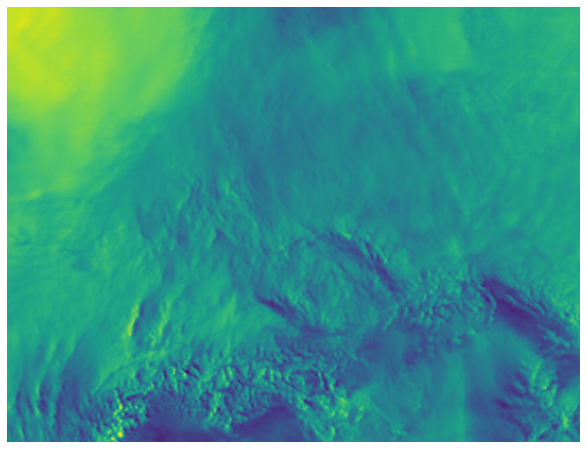

In [79]:
plt.imshow(np.asarray(CE_plotdat[labs[-2]])[0,:,:,0], cmap='viridis', origin='lower')
plt.grid()
plt.xticks([])
plt.yticks([])

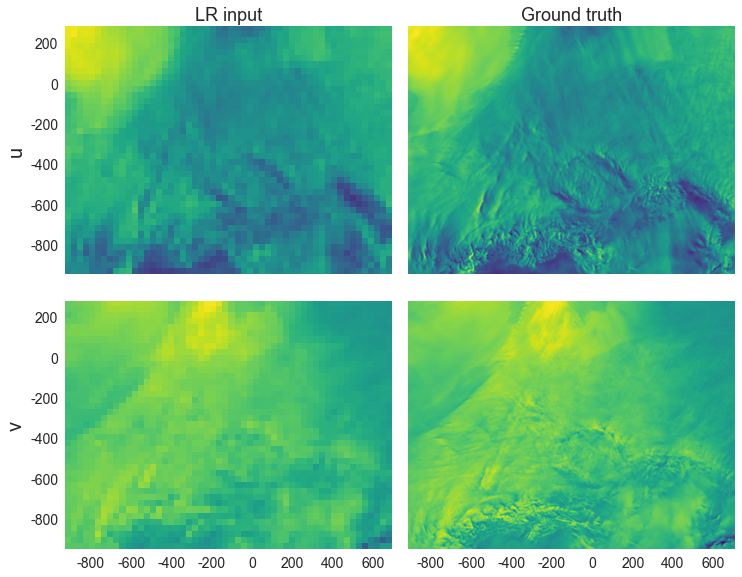

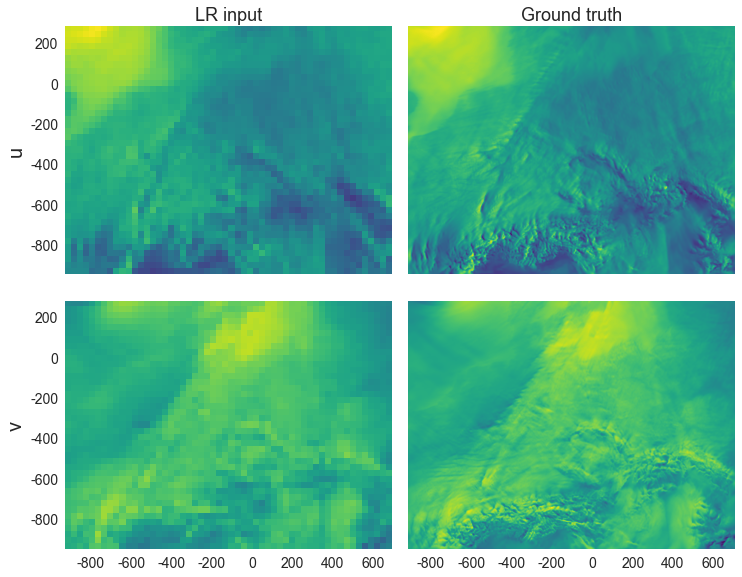

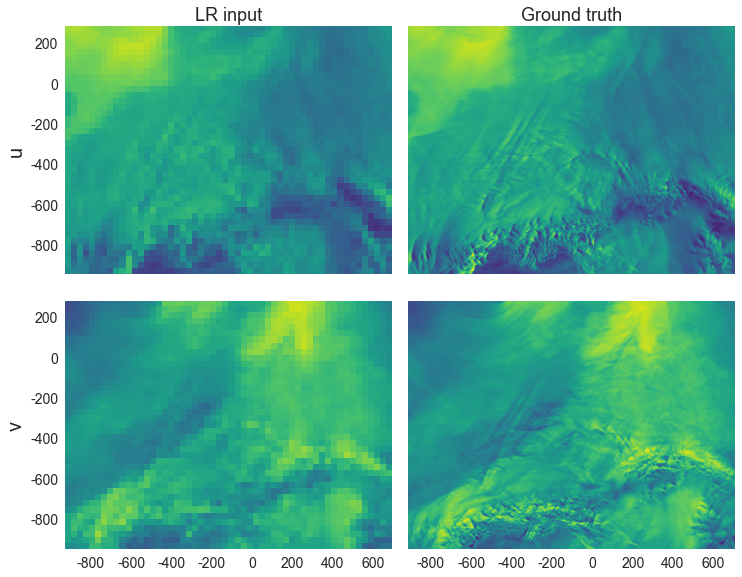

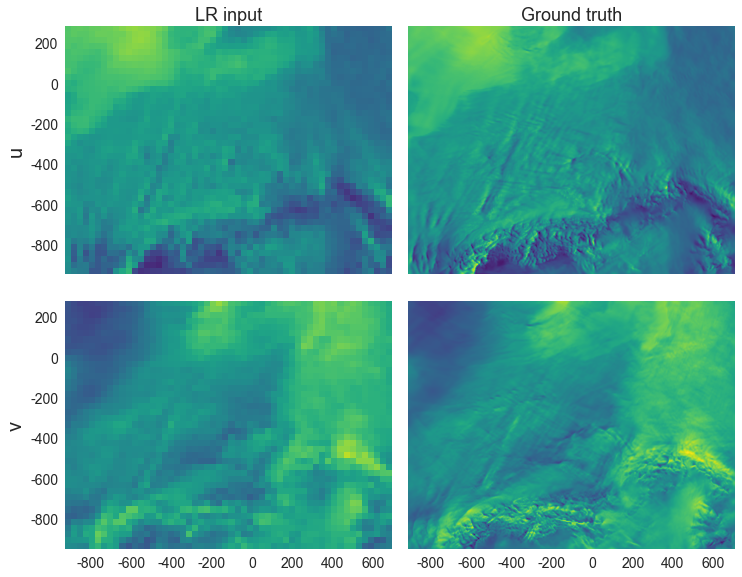

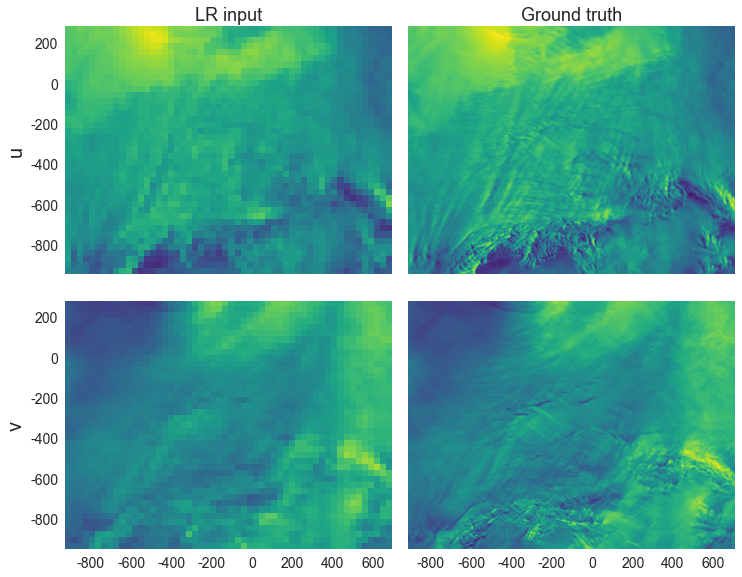

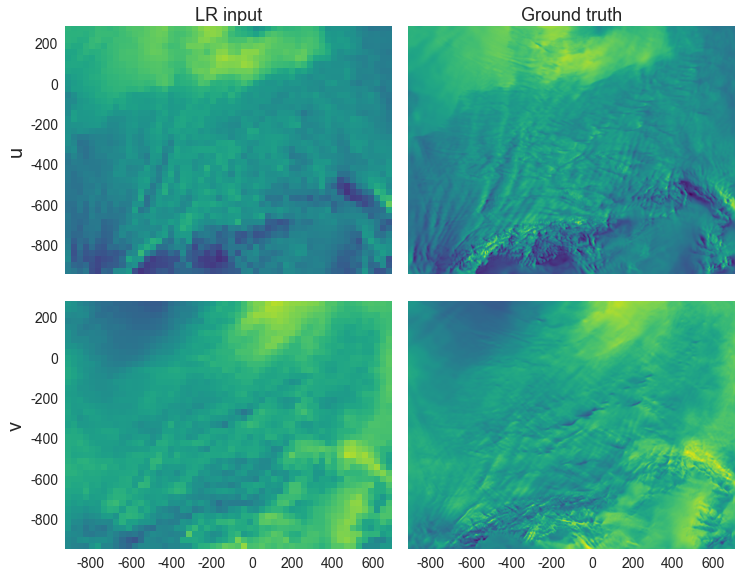

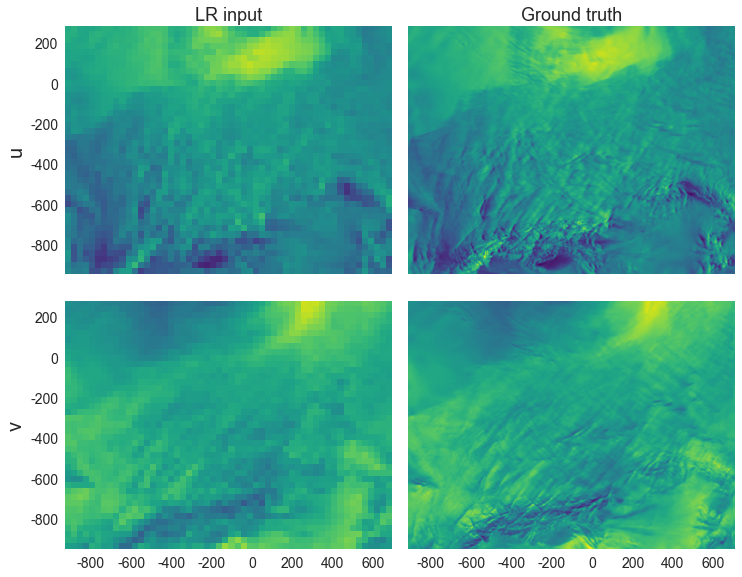

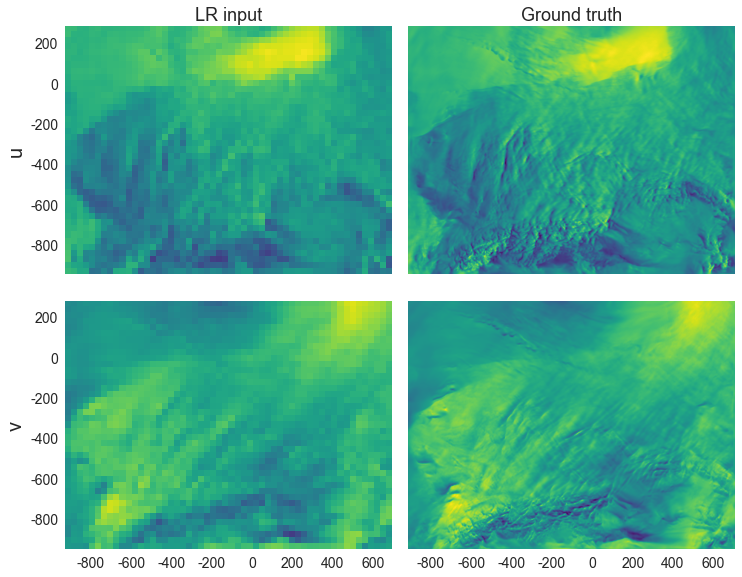

In [382]:
d=CE_plotdat
HR=d["HR"]

LR=d["LR"]

size=[12,8]
Ncol=2
for i in range(HR.shape[0]):
    #plt.figure(figsize=(16, 8))
    fig, ax = plt.subplots(2, Ncol,figsize=size,gridspec_kw = {'wspace':0.05, 'hspace':0.05, "top":0.95,"bottom":0.02})
    #plotting limits based on HR data
    vmin0, vmax0 = np.min(HR[i,:,:,0]), np.max(HR[i,:,:,0])
    vmin1, vmax1 = np.min(HR[i,:,:,1]), np.max(HR[i,:,:,1])

    # HR rightmost plot
    ax_=ax[0,-1]
    ax_.imshow(HR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
    ax_.set_title('Ground truth')

    #plt.colorbar()
    ax_.set_xticks([])
    ax_.set_yticks([])

    #plt.tight_layout()

    ax_=ax[1,-1]
    ax_.imshow(HR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')

    #plt.colorbar()
    #x_.set_xticks([])
    ax_.set_yticks([])
    ax_.set_xticks(xticks_loc)
    ax_.set_xticklabels(plot_xticks)
    ax_.grid()
    #plt.tight_layout()

    # LR leftmost plot
    ax_=ax[0,0]
    ax_.imshow(LR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
    ax_.set_title('LR input')
    ax_.set_ylabel('u')
    ax_.set_xticks([])
    #ax_.set_yticks([])
    #plt.tight_layout()
    ax_.set_yticks([loc/10 for loc in yticks_loc])
    ax_.set_yticklabels(plot_yticks)
    ax_.grid()


    ax_=ax[1,0]
    ax_.imshow(LR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
    #plt.colorbar()
    ax_.set_ylabel('v')
    #ax_.set_xticks([])
    #ax_.set_yticks([])
    #plt.tight_layout()
    ax_.set_yticks([loc/10 for loc in yticks_loc])
    ax_.set_yticklabels(plot_yticks)
    ax_.set_xticks([loc/10 for loc in xticks_loc])
    ax_.set_xticklabels(plot_xticks)
    ax_.grid()

In [130]:
GB_plotdat=get_plot_examples(models=models,labs=labs,file="P-GB-2006-2007-01-01_dataSR.npy",dom="GB")

wind-20220524-135041
wind-20220527-191118
wind-20220528-031534
wind-20220602-122733
wind-20220603-122238
baseline done


In [181]:
plot_SR_HR_data_vert(CE_plotdat,"imgs/CE",plot_keys_noHR,[6,10],
                     xticks_loc=xticks_loc_CE[1::2],plot_xticks=plot_xticks_CE[1::2],
                     yticks_loc=yticks_loc_CE,plot_yticks=plot_yticks_CE)

No HR


In [182]:
plot_SR_HR_data_vert(GB_plotdat,"imgs/GB",plot_keys_noHR,[4,10],
                     xticks_loc=xticks_loc_GB[1::3],plot_xticks=plot_xticks_GB[1::3],
                     yticks_loc=yticks_loc_GB[1::2],plot_yticks=plot_yticks_GB[1::2])

No HR


In [99]:
plot_SR_HR_data(CE_plotdat,"imgs/HR_CE",plot_keys_HR,[12,3])
plot_SR_HR_data(CE_plotdat,"imgs/noHR_CE",plot_keys_noHR,[12,3])

No HR
No HR


In [208]:
plot_SR_HR_data(GB_plotdat,"imgs/HR_GB",plot_keys_HR,[8,4],
                xticks_loc=xticks_loc_GB[1::3],plot_xticks=plot_xticks_GB[1::3],
                yticks_loc=yticks_loc_GB[1::2],plot_yticks=plot_yticks_GB[1::2])
plot_SR_HR_data(GB_plotdat,"imgs/noHR_GB",plot_keys_noHR,[8,4],
                xticks_loc=xticks_loc_GB[1::3],plot_xticks=plot_xticks_GB[1::3],
                yticks_loc=yticks_loc_GB[1::2],plot_yticks=plot_yticks_GB[1::2])

No HR
No HR


###  Climatologies

In [17]:
models

['wind-20220524-135041',
 'wind-20220527-191118',
 'wind-20220528-031534',
 'wind-20220602-122733',
 'wind-20220603-122238',
 'Bicubic']

In [ ]:
p0="//smb.uni-oldenburg.de/hpc_data/thesis/data"
mu_CNN=np.load("/".join([p0,"out",models[1],"meanWS_CE.npy"]))
mu3_CNN=np.load("/".join([p0,"out",models[1],"meanWScube_CE.npy"]))
var_CNN=np.load("/".join([p0,"out",models[1],"varWS_CE.npy"]))
mu_GAN=np.load("/".join([p0,"out",models[-2],"meanWS_CE.npy"]))
mu3_GAN=np.load("/".join([p0,"out",models[-2],"meanWScube_CE.npy"]))
var_GAN=np.load("/".join([p0,"out",models[-2],"varWS_CE.npy"]))

mu_NEWA=np.load("/".join([p0,"test/clima","meanWS_CE.npy"]))
mu3_NEWA=np.load("/".join([p0,"test/clima","meanWScube_CE.npy"]))
var_NEWA=np.load("/".join([p0,"test/clima","varWS_CE.npy"]))

In [ ]:
CE_y=grid_CE["sn"]/1e3
CE_x=grid_CE["we"]/1e3

In [ ]:
ds = xr.Dataset(
    data_vars=dict(
        mu=(["y","x"], mu_NEWA)
    ),
    coords=dict(
        x=(["x"], CE_x),
        y=(["y"], CE_y),
    ),
    attrs=dict(description="coords with vectors"),
)

In [ ]:
mu_GAN[230,185]

In [ ]:
ds.isel(y=230,x=185)

In [ ]:
ds.mu.plot()
xticks,_=plt.xticks()
yticks,_=plt.yticks()
#plt.plot(ds.isel(y=270,x=200).x,ds.isel(y=270,x=200).y,"o")
plt.plot(ds.isel(y=320,x=120).x,ds.isel(y=320,x=120).y,"ro",markersize=10)
#plt.plot(ds.isel(y=75,x=190).x,ds.isel(y=75,x=190).y,"o")
#plt.plot(ds.isel(y=80,x=190).x,ds.isel(y=80,x=190).y,"o")
plt.plot(ds.isel(y=230,x=185).x,ds.isel(y=230,x=185).y,"ro",markersize=10)
plt.plot(ds.isel(y=240,x=100).x,ds.isel(y=240,x=100).y,"ro",markersize=10)

In [ ]:
k,A=Weibull_fitter_u3(mu_NEWA[80,190],mu3_NEWA[80,190])
fig, ax = plt.subplots()
x = np.arange(0, 25 + 0.1, 0.1)
ax.plot(x,
        stats.weibull_min.pdf(
            x,
            c=k,
            scale=A),
        '--r',
        label='Fitted')

In [ ]:
def get_tick_loc(ticks,coord):
    loc=[]
    for tick in ticks:
        if tick<=0:
            loc+=[np.argmin(np.abs(coord+np.abs(tick)))]
        else:
            loc+=[np.argmin(np.abs(coord-tick))]

    return loc

xticks_loc=get_tick_loc(xticks[1:-1],CE_x)
yticks_loc=get_tick_loc(yticks[1:-1],CE_y)
plot_yticks=[int(tick) for tick in yticks[1:-1]]
plot_xticks=[int(tick) for tick in xticks[1:-1]]

In [ ]:
ds.close()

In [ ]:
fig, ax = plt.subplots(2,3,figsize=[15,7],gridspec_kw = {'wspace':0.05, 'hspace':0.05, "top":0.95,"bottom":0.02})

## NEWA
ax_=ax[0,0]
ax_.set_title("Target")
ax_.set_yticks(yticks_loc)
ax_.set_yticklabels(plot_yticks)
ax_.set_xticks([])
ax_.grid()
im0=ax_.imshow(mu_NEWA, vmin=0, vmax=np.max(mu_NEWA), cmap='viridis', origin='lower')
ax_.set_ylabel("Climatologic mean")

ax_=ax[1,0]
im1=ax_.imshow(np.sqrt(var_NEWA), vmin=np.min(np.sqrt(var_NEWA)), vmax=np.max(np.sqrt(var_NEWA)), cmap='viridis', origin='lower')

ax_.set_xticks(xticks_loc)
ax_.set_xticklabels(plot_xticks)
ax_.set_yticks(yticks_loc)
ax_.set_yticklabels(plot_yticks)
ax_.grid()
ax_.set_ylabel("Climatologic std")


## CNN1
ax_=ax[0,1]
ax_.set_yticks([])
ax_.set_xticks([])
ax_.grid()
ax_.imshow(mu_CNN, vmin=0, vmax=np.max(mu_NEWA), cmap='viridis', origin='lower')
ax_.set_title("CNN1 - HR static")
ax_=ax[1,1]
ax_.imshow(np.sqrt(var_CNN), vmin=np.min(np.sqrt(var_NEWA)), vmax=np.max(np.sqrt(var_NEWA)), cmap='viridis', origin='lower')

ax_.set_xticks(xticks_loc)
ax_.set_xticklabels(plot_xticks)
ax_.set_yticklabels([])
ax_.grid()


## WGAN
ax_=ax[0,2]
ax_.set_title("WGAN - HR static")
ax_.set_yticks([])
ax_.set_xticks([])
ax_.grid()
ax_.imshow(mu_GAN, vmin=0, vmax=np.max(mu_NEWA), cmap='viridis', origin='lower')

ax_=ax[1,2]
ax_.imshow(np.sqrt(var_GAN), vmin=np.min(np.sqrt(var_NEWA)), vmax=np.max(np.sqrt(var_NEWA)), cmap='viridis', origin='lower')

ax_.set_xticks(xticks_loc)
ax_.set_xticklabels(plot_xticks)
ax_.set_yticklabels([])
ax_.grid()


fig.subplots_adjust(right=0.95)
cbar_ax0 = fig.add_axes([0.96, 0.52, 0.03, 0.4])
cbar=fig.colorbar(im0, cax=cbar_ax0)#,label="m/s")
cbar.set_label("m/s") 
cbar_ax1 = fig.add_axes([0.96, 0.05, 0.03, 0.4])
cbar=fig.colorbar(im1, cax=cbar_ax1)
cbar.set_label("m/s") 
#plt.savefig('Clima_mean_CE.eps', format='eps', bbox_inches='tight')



# ax[0].imshow(mu_CNN, vmin=0, vmax=np.max(mu_CNN), cmap='viridis', origin='lower')
# ax[1].imshow(np.sqrt(var_CNN), vmin=np.min(np.sqrt(var_CNN)), vmax=np.max(np.sqrt(var_CNN)), cmap='viridis', origin='lower')
# ax[0].set_yticks(yticks_loc)
# ax[0].set_yticklabels(plot_yticks)
# ax[0].set_xticks(xticks_loc)
# ax[0].set_xticklabels(plot_xticks)
# ax[1].set_xticks(xticks_loc)
# ax[1].set_xticklabels(plot_xticks)
# ax[1].set_yticklabels([])
# ax[0].grid()
# ax[1].grid()

In [176]:
models[1]

'wind-20220527-191118'

In [18]:
p0="//smb.uni-oldenburg.de/hpc_data/thesis/data"
mu_CNN=np.load("/".join([p0,"out",models[1],"meanWS_GB.npy"]))
#mu3_CNN=np.load("/".join([p0,"out",models[1],"meanWScube_GB.npy"]))
var_CNN=np.load("/".join([p0,"out",models[1],"varWS_GB.npy"]))
mu_GAN=np.load("/".join([p0,"out",models[-2],"meanWS_GB.npy"]))
#mu3_GAN=np.load("/".join([p0,"out",models[-2],"meanWScube_GB.npy"]))
var_GAN=np.load("/".join([p0,"out",models[-2],"varWS_GB.npy"]))

mu_NEWA=np.load("/".join([p0,"test/clima","meanWS_GB.npy"]))
mu3_NEWA=np.load("/".join([p0,"test/clima","meanWScube_GB.npy"]))
var_NEWA=np.load("/".join([p0,"test/clima","varWS_GB.npy"]))

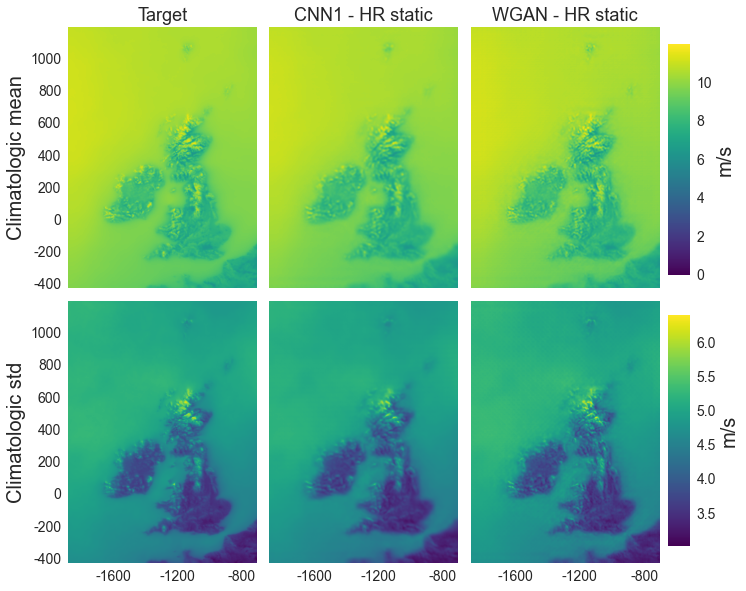

In [21]:
fig, ax = plt.subplots(2,3,figsize=[10,8],gridspec_kw = {'wspace':0.05, 'hspace':0.05, "top":0.95,"bottom":0.02})

## NEWA
ax_=ax[0,0]
ax_.set_title("Target")
ax_.set_yticks(yticks_loc_GB)
ax_.set_yticklabels(plot_yticks_GB)
ax_.set_xticks([])
ax_.grid()
im0=ax_.imshow(mu_NEWA, vmin=0, vmax=np.max(mu_NEWA), cmap='viridis', origin='lower')
ax_.set_ylabel("Climatologic mean")

ax_=ax[1,0]
im1=ax_.imshow(np.sqrt(var_NEWA), vmin=np.min(np.sqrt(var_NEWA)), vmax=np.max(np.sqrt(var_NEWA)), cmap='viridis', origin='lower')

ax_.set_xticks(xticks_loc_GB[1::2])
ax_.set_xticklabels(plot_xticks_GB[1::2])
ax_.set_yticks(yticks_loc_GB)
ax_.set_yticklabels(plot_yticks_GB)
ax_.grid()
ax_.set_ylabel("Climatologic std")


## CNN1
ax_=ax[0,1]
ax_.set_yticks([])
ax_.set_xticks([])
ax_.grid()
ax_.imshow(mu_CNN, vmin=0, vmax=np.max(mu_NEWA), cmap='viridis', origin='lower')
ax_.set_title("CNN1 - HR static")
ax_=ax[1,1]
ax_.imshow(np.sqrt(var_CNN), vmin=np.min(np.sqrt(var_NEWA)), vmax=np.max(np.sqrt(var_NEWA)), cmap='viridis', origin='lower')

ax_.set_xticks(xticks_loc_GB[1::2])
ax_.set_xticklabels(plot_xticks_GB[1::2])
ax_.set_yticklabels([])
ax_.grid()


## WGAN
ax_=ax[0,2]
ax_.set_title("WGAN - HR static")
ax_.set_yticks([])
ax_.set_xticks([])
ax_.grid()
ax_.imshow(mu_GAN, vmin=0, vmax=np.max(mu_NEWA), cmap='viridis', origin='lower')

ax_=ax[1,2]
ax_.imshow(np.sqrt(var_GAN), vmin=np.min(np.sqrt(var_NEWA)), vmax=np.max(np.sqrt(var_NEWA)), cmap='viridis', origin='lower')

ax_.set_xticks(xticks_loc_GB[1::2])
ax_.set_xticklabels(plot_xticks_GB[1::2])
ax_.set_yticklabels([])
ax_.grid()


fig.subplots_adjust(right=0.95)
cbar_ax0 = fig.add_axes([0.96, 0.52, 0.03, 0.4])
cbar=fig.colorbar(im0, cax=cbar_ax0)#,label="m/s")
cbar.set_label("m/s") 
cbar_ax1 = fig.add_axes([0.96, 0.05, 0.03, 0.4])
cbar=fig.colorbar(im1, cax=cbar_ax1)
cbar.set_label("m/s") 
plt.savefig('Clima_mean_GB.eps', format='eps', bbox_inches='tight')


### Weibulls

In [29]:
import scipy.stats as stats
from scipy.special import gamma
from scipy import optimize

In [30]:
def Weibull_fitter_u3(mu,mu3):

    def Afunc(k): return (mu3 / gamma(1 + 3 / k))**(1 / 3)
    def zero_func(k): return gamma(1 + 1 / k)**3 / gamma(1 + 3 / k) - mu**3 / mu3

    sol = optimize.fsolve(func=zero_func, x0=2)
    ksol = sol[0]
    if ksol < 1:
        ksol = np.nan
        print("Invalid fit")
    elif ksol > 4:
        ksol = np.nan
    Asol = Afunc(ksol)
    return (ksol, Asol)

In [31]:
k,A=Weibull_fitter_u3(mu_NEWA[70,190],mu3_NEWA[70,190])
fig, ax = plt.subplots()
x = np.arange(0, 25 + 0.1, 0.1)
ax.plot(x,
        stats.weibull_min.pdf(
            x,
            c=k,
            scale=A),
        '--r',
        label='Fitted')

NameError: name 'mu_NEWA' is not defined

### Time seris

In [39]:
diri="//smb.uni-oldenburg.de/hpc_data/thesis/data/ts"
TSfilesCE=glob(diri+"/*CE.json")

In [40]:
file=TSfilesCE[0]
with open(file) as fp:
    d=json.load(fp)

In [124]:
d.keys()

dict_keys(['CNN1 - no static', 'CNN1 - HR static', 'CNN2 - HR static', 'WGAN - no static', 'WGAN - HR static', 'HR'])

In [125]:
def Weibull_fitter_LS(U,nbins=25,lower=0.5,upper=20):
    hist = np.histogram(U, bins=nbins)
    hist_dist = stats.rv_histogram(hist)
    u=np.linspace(lower,upper,nbins)
    FU = hist_dist.cdf(u)
    y=np.log(np.log(1/(1-FU)))
    x=np.log(u)
    #plt.plot(x,y,"o")
    fit=linregress(x,y)
    #plt.plot(x,x*fit[0]+fit[1],"r--")
    #plt.xlabel("$\ln(U)$")
    #plt.ylabel(r"$\ln\left(\ln\left(\frac{1}{1-F(U)}\right)\right)$")
    return fit[0],np.exp(-fit[1]/fit[0])

In [126]:
def get_weibull_dat(d,model,point,bins,meth="moments"):
    ws=np.linalg.norm(np.asarray(d[model][point]),axis=1)
    Uhist = np.histogram(ws, bins=bins, density=True)
    if meth=="moments":
        k,A=Weibull_fitter_u3(np.mean(ws),np.mean(ws**3))
    elif meth=="MLE":
        k,dummy,A=stats.weibull_min.fit(ws,floc=0)
    elif meth=="LS":
        k,A=Weibull_fitter_LS(ws)
    else:
        k,A=np.nan,np.nan
        
    return Uhist[0],k,A

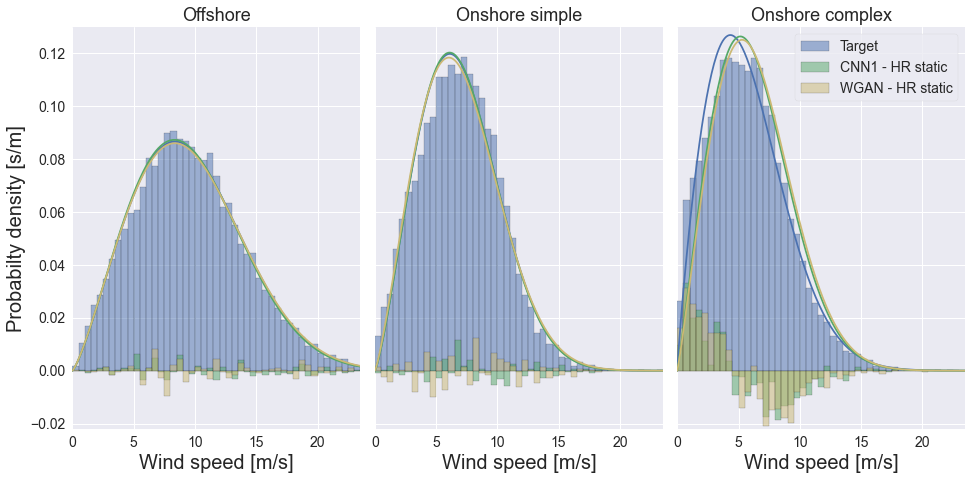

In [127]:
bins=np.arange(0, 24, 0.5)
plot_bins = np.diff(bins) / 2 + bins[:-1]

ylims=(-0.022,0.13)

point="1"
method="moments"

df=pd.DataFrame()

fig,ax= plt.subplots(1,3,figsize=[16,6],gridspec_kw = {'wspace':0.05, 'hspace':0.05, "top":0.95,"bottom":0.02})

hist_HR,k,A=get_weibull_dat(d,"HR",point,bins,meth=method)

ax_=ax[0]
ax_.bar(plot_bins,hist_HR,edgecolor="k",width=0.5,alpha=0.5,label="HR")
x = np.arange(0, bins[-1] + 0.1, 0.1)
ax_.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[0])

model='CNN1 - HR static'
hist,k,A=get_weibull_dat(d,model,point,bins)
ax_.bar(plot_bins,hist-hist_HR,edgecolor="k",width=0.5,alpha=0.5,label=model)
x = np.arange(0, bins[-1] + 0.1, 0.1)
ax_.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[1])

model='WGAN - HR static'
hist,k,A=get_weibull_dat(d,model,point,bins)
ax_.bar(plot_bins,hist-hist_HR,edgecolor="k",width=0.5,alpha=0.5,label=model,color=palette[-2])
ax_.set_xlim(bins[0],bins[-1])
ax_.set_ylim(ylims)
ax_.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[-2])


#plt.legend(frameon=True)
ax_.set_xlabel("Wind speed [m/s]")
ax_.set_ylabel("Probabilty density [s/m]")

ax_.set_title("Offshore")


point="4"

hist_HR,k,A=get_weibull_dat(d,"HR",point,bins,meth=method)

ax_=ax[1]
ax_.bar(plot_bins,hist_HR,edgecolor="k",width=0.5,alpha=0.5,label="HR")
x = np.arange(0, bins[-1] + 0.1, 0.1)
ax_.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[0])

model='CNN1 - HR static'
hist,k,A=get_weibull_dat(d,model,point,bins)
ax_.bar(plot_bins,hist-hist_HR,edgecolor="k",width=0.5,alpha=0.5,label=model)
x = np.arange(0, bins[-1] + 0.1, 0.1)
ax_.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[1])

model='WGAN - HR static'
hist,k,A=get_weibull_dat(d,model,point,bins)
ax_.bar(plot_bins,hist_HR-hist,edgecolor="k",width=0.5,alpha=0.5,label=model,color=palette[-2])
ax_.set_xlim(bins[0],bins[-1])
ax_.set_ylim(ylims)
ax_.grid(True)
ax_.yaxis.set_ticklabels([])
ax_.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[-2])


#plt.legend(frameon=True)
ax_.set_xlabel("Wind speed [m/s]")
#ax_.set_ylabel("Probabilty density [s/m]")
ax_.set_title("Onshore simple")

point="3"

hist_HR,k,A=get_weibull_dat(d,"HR",point,bins,meth=method)

ax_=ax[2]
ax_.bar(plot_bins,hist_HR,edgecolor="k",width=0.5,alpha=0.5,label="Target")
x = np.arange(0, bins[-1] + 0.1, 0.1)
ax_.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[0])

model='CNN1 - HR static'
hist,k,A=get_weibull_dat(d,model,point,bins)
ax_.bar(plot_bins,hist_HR-hist,edgecolor="k",width=0.5,alpha=0.5,label=model)
x = np.arange(0, bins[-1] + 0.1, 0.1)
ax_.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[1])

model='WGAN - HR static'
hist,k,A=get_weibull_dat(d,model,point,bins)
ax_.bar(plot_bins,hist_HR-hist,edgecolor="k",width=0.5,alpha=0.5,label=model,color=palette[-2])
ax_.set_xlim(bins[0],bins[-1])
ax_.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[-2])

ax_.set_ylim(ylims)
ax_.grid(True)
ax_.yaxis.set_ticklabels([])

ax_.set_title("Onshore complex")


ax_.legend(frameon=True)
ax_.set_xlabel("Wind speed [m/s]")
#ax_.set_ylabel("Probabilty density [s/m]")
plt.savefig('weibulls.png', dpi=200, bbox_inches='tight')

In [128]:
np.mean(np.linalg.norm(d["HR"]["3"],axis=1))

5.765451007105423

In [129]:
np.mean(np.linalg.norm(d["CNN1 - HR static"]["3"],axis=1))

6.205623256814677

In [ ]:
point="3"

hist_HR,k_HR,A_R=get_weibull_dat(d,"HR",point,bins,meth=method)

model='CNN1 - HR static'
hist,k,A=get_weibull_dat(d,model,point,bins)

In [131]:
df=pd.DataFrame()
for point in ["1","4","3"]:
    tab=pd.DataFrame()
    arrays = [
        [point, point,point],
        ["u","k","A"],
    ]
    tuples = list(zip(*arrays))
    index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
    for model in ["HR","CNN1 - HR static", "WGAN - HR static"]:
        ws=np.linalg.norm(np.asarray(d[model][point]),axis=1)
        k,A=Weibull_fitter_u3(np.mean(ws),np.mean(ws**3))
        tab=pd.concat([tab,pd.DataFrame([[np.mean(ws),k,A]], index=[model], columns=index)])
    tab[point,"du"]=(tab[point]["u"]-tab[point]["u"][0])/tab[point]["u"][0]*100
    tab[point,"dk"]=(tab[point]["k"]-tab[point]["k"][0])/tab[point]["k"][0]*100
    tab[point,"dA"]=(tab[point]["A"]-tab[point]["A"][0])/tab[point]["A"][0]*100
    
    df=pd.concat([df,tab],axis=1)

In [132]:
df

first                    1                                                     \
second                   u         k          A        du        dk        dA   
HR                9.570207  2.267382  10.804196  0.000000  0.000000  0.000000   
CNN1 - HR static  9.509802  2.270485  10.735871 -0.631170  0.136838 -0.632392   
WGAN - HR static  9.596766  2.253662  10.834727  0.277527 -0.605109  0.282588   

first                    4                                                    \
second                   u         k         A        du        dk        dA   
HR                6.965148  2.285833  7.862627  0.000000  0.000000  0.000000   
CNN1 - HR static  6.946357  2.290021  7.841264 -0.269789  0.183191 -0.271706   
WGAN - HR static  6.953434  2.245085  7.850632 -0.168183 -1.782651 -0.152552   

first                    3                                                     
second                   u         k         A        du         dk        dA  
HR                5.765451  1.878018  6.494738  0.000000   0.000000  0.000000  
CNN1 - HR static  6.205623  2.098530  7.006479  7.634654  11.741778  7.879328  
WGAN - HR static  6.319063  2.122810  7.135014  9.602236  13.034645  9.858392

In [133]:
df2latex(df.T,1)


\begin{tabular}{llrrr}
\toprule
  &    &   HR &  CNN1 - HR static &  WGAN - HR static \\
first & second &      &                   &                   \\
\midrule
1 & u &  9.6 &               9.5 &               9.6 \\
  & k &  2.3 &               2.3 &               2.3 \\
  & A & 10.8 &              10.7 &              10.8 \\
  & du &  0.0 &              -0.6 &               0.3 \\
  & dk &  0.0 &               0.1 &              -0.6 \\
  & dA &  0.0 &              -0.6 &               0.3 \\
4 & u &  7.0 &               6.9 &               7.0 \\
  & k &  2.3 &               2.3 &               2.2 \\
  & A &  7.9 &               7.8 &               7.9 \\
  & du &  0.0 &              -0.3 &              -0.2 \\
  & dk &  0.0 &               0.2 &              -1.8 \\
  & dA &  0.0 &              -0.3 &              -0.2 \\
3 & u &  5.8 &               6.2 &               6.3 \\
  & k &  1.9 &               2.1 &               2.1 \\
  & A &  6.5 &               7.0 &             

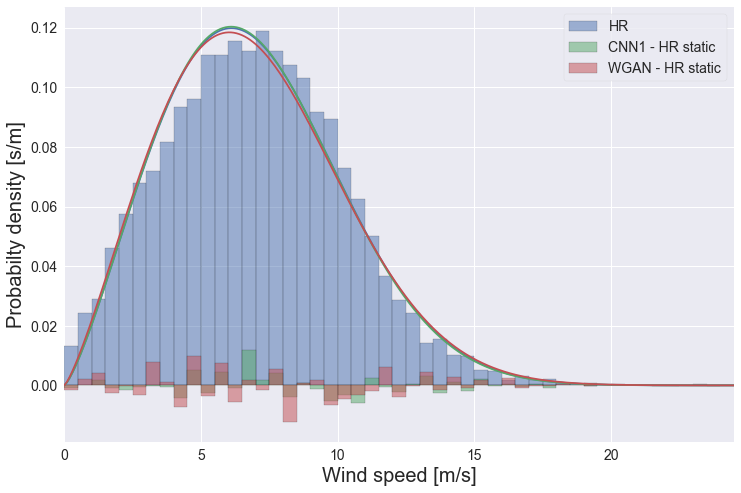

In [337]:
bins=np.arange(0, 25, 0.5)
plot_bins = np.diff(bins) / 2 + bins[:-1]

point="4"
method="moments"


hist_HR,k,A=get_weibull_dat(d,"HR",point,bins,meth=method)

plt.bar(plot_bins,hist_HR,edgecolor="k",width=0.5,alpha=0.5,label="HR")
x = np.arange(0, bins[-1] + 0.1, 0.1)
plt.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[0])

model='CNN1 - HR static'
hist,k,A=get_weibull_dat(d,model,point,bins)
plt.bar(plot_bins,hist-hist_HR,edgecolor="k",width=0.5,alpha=0.5,label=model)
x = np.arange(0, bins[-1] + 0.1, 0.1)
plt.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[-2])

model='WGAN - HR static'
hist,k,A=get_weibull_dat(d,model,point,bins)
plt.bar(plot_bins,hist-hist_HR,edgecolor="k",width=0.5,alpha=0.5,label=model)
x = np.arange(0, bins[-1] + 0.1, 0.1)
plt.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[-2])


plt.legend(frameon=True)
plt.xlim(bins[0],bins[-1])
plt.xlabel("Wind speed [m/s]")
plt.ylabel("Probabilty density [s/m]")
plt.show()

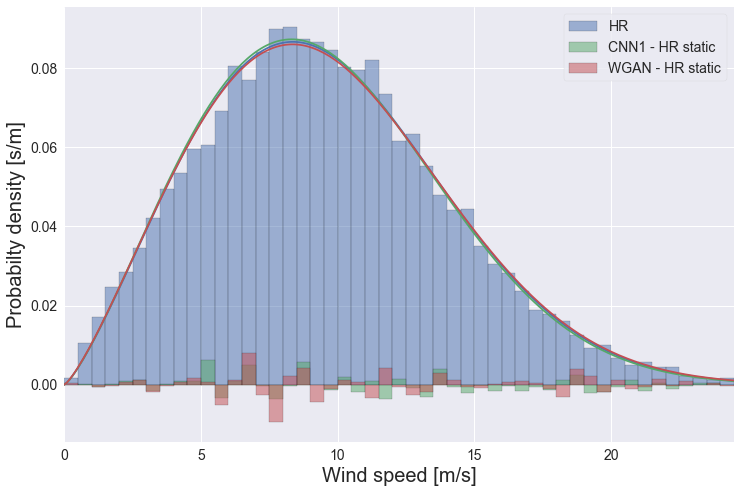

In [332]:
bins=np.arange(0, 25, 0.5)
plot_bins = np.diff(bins) / 2 + bins[:-1]

point="1"
method="moments"


hist_HR,k,A=get_weibull_dat(d,"HR",point,bins,meth=method)

plt.bar(plot_bins,hist_HR,edgecolor="k",width=0.5,alpha=0.5,label="HR")
x = np.arange(0, bins[-1] + 0.1, 0.1)
plt.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[0])

model='CNN1 - HR static'
hist,k,A=get_weibull_dat(d,model,point,bins)
plt.bar(plot_bins,hist-hist_HR,edgecolor="k",width=0.5,alpha=0.5,label=model)
x = np.arange(0, bins[-1] + 0.1, 0.1)
plt.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[1])

model='WGAN - HR static'
hist,k,A=get_weibull_dat(d,model,point,bins)
plt.bar(plot_bins,hist-hist_HR,edgecolor="k",width=0.5,alpha=0.5,label=model)
x = np.arange(0, bins[-1] + 0.1, 0.1)
plt.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-',color=palette[2])


plt.legend(frameon=True)
plt.xlim(bins[0],bins[-1])
plt.xlabel("Wind speed [m/s]")
plt.ylabel("Probabilty density [s/m]")
plt.show()

No handles with labels found to put in legend.


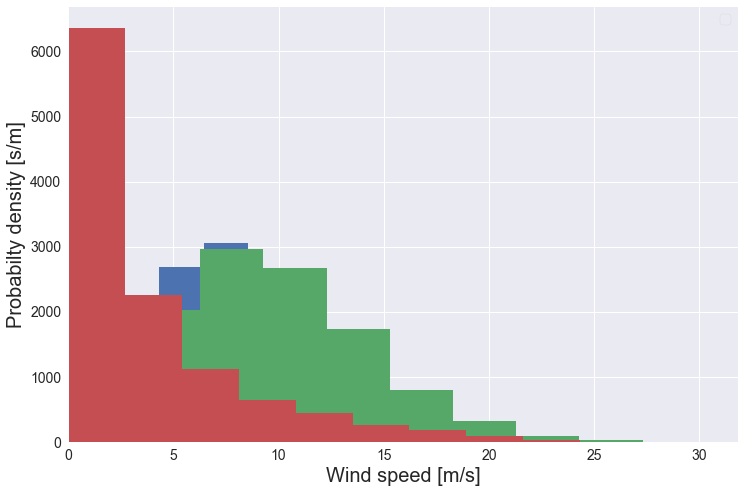

In [73]:
plt.hist(np.linalg.norm(np.asarray(d["HR"]["0"]),axis=1))
plt.hist(np.linalg.norm(np.asarray(d["HR"]["1"]),axis=1))
plt.hist(np.linalg.norm(np.asarray(d["HR"]["2"]),axis=1))



In [41]:
from windrose import WindroseAxes

In [42]:
def wind_rose0(uv, savefig=0, p=""):  # , fmax=35.):
    wdir = np.rad2deg(np.arctan2(uv[:,0], uv[:,1])) + 180
    wspd = np.linalg.norm(uv,axis=1)
    fig = plt.figure(figsize=(12, 10))
    rect = [0.1, 0.1, 0.5, 0.5]

    ax = WindroseAxes(fig, rect)
    fig.add_axes(ax)
    colors = [
        "black",
        "blue",
        "dodgerblue",
        "limegreen",
        "gold",
        "red",
        "darkred"]
    ax.bar(wdir, wspd,
           normed=True, opening=0.8, bins=[0, 2.5, 5, 7.5, 10, 15, 20],
           colors=colors, nsector=12)

    ax.legend(loc='upper left', fontsize=9, frameon=True, fancybox=True)
    if savefig:
        #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        #fig.savefig(os.path.join(p, "rose_all"), bbox_inches=extent)
        plt.savefig('rose_'+p+'.png', dpi=200, bbox_inches='tight')


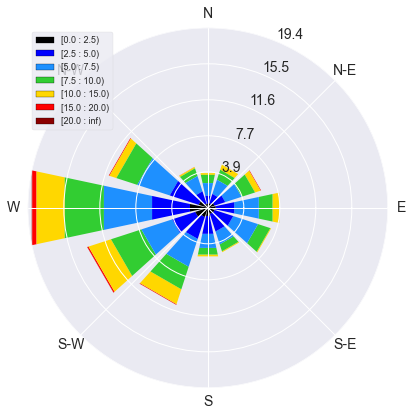

In [45]:
wind_rose0(np.asarray(d["WGAN - HR static"]["3"]),1,"WGAN - HR static")

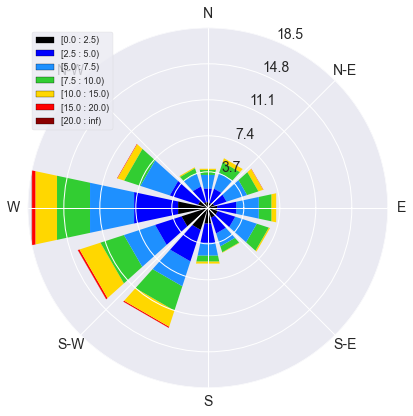

In [46]:
wind_rose0(np.asarray(d["HR"]["3"]),1,"Target")

###  model error analysis

In [22]:
diri="//smb.uni-oldenburg.de/hpc_data/thesis/data/results"
NfilesCE=glob(diri+"/*CE-NodewiseStat.json")
print(NfilesCE)
NfilesGB=glob(diri+"/*GB-NodewiseStat.json")

print(NfilesGB)
DfilesCE=glob(diri+"/*CE-DomainStat.json")
print(DfilesCE)
DfilesGB=glob(diri+"/*GB-DomainStat.json")
print(DfilesGB)

['//smb.uni-oldenburg.de/hpc_data/thesis/data/results\\wind-20220403-215439_20220404-104804__wind-20220519-113058__wind-20220520-215250__wind-20220419-143003_20220420-182503__wind-20220413-182848-CE-NodewiseStat.json', '//smb.uni-oldenburg.de/hpc_data/thesis/data/results\\wind-20220403-215439_20220404-104804__wind-20220519-113058__wind-20220520-215250__wind-20220419-143003_20220420-182503__wind-20220413-182848__wind-20220430-180155__wind-20220429-211329-CE-NodewiseStat.json', '//smb.uni-oldenburg.de/hpc_data/thesis/data/results\\wind-20220430-180155__wind-20220429-211329-CE-NodewiseStat.json', '//smb.uni-oldenburg.de/hpc_data/thesis/data/results\\wind-20220524-135041__wind-20220527-191118__wind-20220528-031534-CE-NodewiseStat.json', '//smb.uni-oldenburg.de/hpc_data/thesis/data/results\\wind-20220528-031534__wind-20220602-122733__wind-20220603-122238-CE-NodewiseStat.json', '//smb.uni-oldenburg.de/hpc_data/thesis/data/results\\wind-20220529-120253-CE-NodewiseStat.json']
['//smb.uni-olden

In [23]:
def get_dict_and_merge(files):
    d_all={}
    for file in files:
        with open(file) as fp:
            d=json.load(fp)
        d_all={**d_all, **d} #python version > 3.5
    return d_all

In [136]:
NfilesCE=["/".join(["Data",f.split("\\")[-1]]) for f in NfilesCE[-3:-1]]
NfilesGB=["/".join(["Data",f.split("\\")[-1]]) for f in NfilesGB[:-1]]

In [137]:
dn_CE=get_dict_and_merge(NfilesCE)#["//smb.uni-oldenburg.de/hpc_data/thesis/data/results\\wind-20220528-031534__wind-20220602-122733__wind-20220603-122238-CE-NodewiseStat.json"])#NfilesCE[-3:-1])

dn_GB=get_dict_and_merge(NfilesGB)


In [138]:
np.asarray(dn_GB["WGAN - HR static"]["MD"])[230,185]

-0.4872576226601355

In [22]:
np.asarray(dn_GB["WGAN - HR static"]["MD"])[-1,:]

array([ 0.23076556,  0.05208037,  0.0668665 ,  0.04110336,  0.0472937 ,
        0.05905472,  0.03246926,  0.02062042, -0.02529796,  0.0173521 ,
        0.06138166,  0.06855389,  0.06536828,  0.0228435 ,  0.03155227,
        0.04994781,  0.01441465, -0.01323887, -0.06286005, -0.03125732,
        0.00581737,  0.01364535,  0.02334122, -0.0074849 , -0.00393417,
        0.01256657, -0.00280533, -0.016557  , -0.06031164, -0.02475534,
        0.0159968 ,  0.02982309,  0.03853954,  0.00676559,  0.01306112,
        0.03126199,  0.00921403, -0.00681717, -0.05016391, -0.0241941 ,
        0.00981826,  0.02340087,  0.03736798,  0.01022829,  0.01691696,
        0.04050002,  0.02318525,  0.00984279, -0.03574139, -0.0179013 ,
        0.01439404,  0.0317472 ,  0.04584385,  0.01961287,  0.02631855,
        0.04885165,  0.03229851,  0.01831285, -0.02197449, -0.00252225,
        0.03020999,  0.04775476,  0.06449536,  0.03684538,  0.03891079,
        0.05895648,  0.03769833,  0.02176578, -0.01661529,  0.00

In [196]:
def plot_mean_uv_error(d,path,metric="MSE",keys=None,size=[10,6]):
    if keys is None:
        keys=list(d.keys())
    
    Ncol=len(keys)
    
    #find min and max
    vmin0,vmax0=1,0
    vmin1,vmax1=1,0
    for key in keys:
        vmin0_key, vmax0_key = np.min(np.asarray(d[key][metric])[:,:,0]), np.percentile(np.asarray(d[key][metric])[:,:,0],99)
        vmin1_key, vmax1_key = np.min(np.asarray(d[key][metric])[:,:,1]), np.percentile(np.asarray(d[key][metric])[:,:,1],99)
        
        if vmin0_key <vmin0:
            vmin0=vmin0_key
        if vmin1_key <vmin1:
            vmin1=vmin1_key
        if vmax0_key >vmax0:
            vmax0=vmax0_key
        if vmax1_key >vmax1:
            vmax1=vmax1_key
            
        
    fig, ax = plt.subplots(2, Ncol,figsize=size,gridspec_kw = {'wspace':0.05, 'hspace':0.05, "top":0.95,"bottom":0.02})
    for i,key in enumerate(keys):
        ax_=ax[0,i]
        im0=ax_.imshow(np.asarray(d[key][metric])[:, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
        ax_.set_title(key, fontsize=12)
        if i==0:
            ax_.set_ylabel('u', fontsize=18)
        ax_.set_xticks([], [])
        ax_.set_yticks([], [])
        

        ax_=ax[1,i]
        im1=ax_.imshow(np.asarray(d[key][metric])[:, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
        ax_.set_xticks([], [])
        ax_.set_yticks([], [])
        if i==0:
            ax_.set_ylabel('v', fontsize=18)

        
    fig.subplots_adjust(right=0.95)
    cbar_ax0 = fig.add_axes([0.96, 0.52, 0.03, 0.4])
    fig.colorbar(im0, cax=cbar_ax0)
    cbar_ax0.set_label('m/s')
    cbar_ax1 = fig.add_axes([0.96, 0.05, 0.03, 0.4])
    fig.colorbar(im1, cax=cbar_ax1)
    #plt.savefig(path+'_HRvsSRimg{0:05d}.png'.format(i), dpi=200, bbox_inches='tight')
    #plt.close()
    
def plot_mean_error(d,path,keys=None,size=[10,6],savefig=0,dom="",maxmin=None,
                    xticks_loc=[],plot_xticks=[],
                    yticks_loc=[],plot_yticks=[]):
    if keys is None:
        keys=list(d.keys())
    
    Ncol=len(keys)
    
    #find min and max
    if maxmin is not None:
        vmin0,vmax0, vmin1,vmax1=maxmin
    else:
        vmin0,vmax0, vmin1,vmax1=get_plot_limits(d,keys)
#     for key in keys:
#         vmin0_key, vmax0_key = np.percentile(np.asarray(d[key]["MD"])[:,:],1), np.percentile(np.asarray(d[key]["MD"])[:,:],99)
#         vmin1_key, vmax1_key = np.min(0.5*(1-np.asarray(d[key]["CD"])[:,:])), np.percentile(0.5*(1-np.asarray(d[key]["CD"])[:,:]),99)
        
#         if vmin0_key <vmin0:
#             vmin0=vmin0_key
#         if vmin1_key <vmin1:
#             vmin1=vmin1_key
#         if vmax0_key >vmax0:
#             vmax0=vmax0_key
#         if vmax1_key >vmax1:
#             vmax1=vmax1_key
            
        
    fig, ax = plt.subplots(2, Ncol,figsize=size,gridspec_kw = {'wspace':0.05, 'hspace':0.05, "top":0.95,"bottom":0.02})
    for i,key in enumerate(keys):
        ax_=ax[0,i]
        im0=ax_.imshow(np.asarray(d[key]["MD"])[:, :], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
        ax_.set_title(key.replace(" - no static", ""))
        ax_.set_xticks([])
        ax_.set_yticks([])
        if i==0:
            ax_.set_ylabel('MD')
            ax_.set_yticks(yticks_loc)
            ax_.set_yticklabels(plot_yticks)
            ax_.grid()

        

        ax_=ax[1,i]
        im1=ax_.imshow(0.5*(1-np.asarray(d[key]["CD"])[:, :]), vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
        ax_.set_xticks([])
        ax_.set_yticks([])
        if i==0:
            ax_.set_ylabel('CosDis')
            ax_.set_yticks(yticks_loc)
            ax_.set_yticklabels(plot_yticks)
        ax_.set_xticks(xticks_loc)
        ax_.set_xticklabels(plot_xticks)
        ax_.grid()
        #ax_.tick_params(bottom=True)
        

        
    fig.subplots_adjust(right=0.95)
    cbar_ax0 = fig.add_axes([0.96, 0.52, 0.03, 0.4])
    cbar=fig.colorbar(im0, cax=cbar_ax0)#,label="m/s")
    cbar.set_label("m/s") 
    cbar_ax1 = fig.add_axes([0.96, 0.05, 0.03, 0.4])
    fig.colorbar(im1, cax=cbar_ax1)
    if savefig:
        plt.savefig(path+'NodeWiseError'+dom+'.eps', format='eps', bbox_inches='tight')
    #plt.close()
    



In [313]:
plot_keys=['Bicubic','CNN1 - no static', 'CNN1 - HR static', 'CNN2 - HR static', 'WGAN - no static','WGAN - HR static']
plot_keys_noHR=['Bicubic','CNN1 - no static', 'WGAN - no static']
plot_keys_HR=['CNN1 - HR static', 'CNN2 - HR static','WGAN - HR static']

In [186]:
def get_plot_limits(d,keys):
    vmin0,vmax0=1,0
    vmin1,vmax1=1,0
    for key in keys:
        vmin0_key, vmax0_key = np.percentile(np.asarray(d[key]["MD"])[:,:],1), np.percentile(np.asarray(d[key]["MD"])[:,:],99)
        vmin1_key, vmax1_key = np.min(0.5*(1-np.asarray(d[key]["CD"])[:,:])), np.percentile(0.5*(1-np.asarray(d[key]["CD"])[:,:]),99)

        if vmin0_key <vmin0:
            vmin0=vmin0_key
        if vmin1_key <vmin1:
            vmin1=vmin1_key
        if vmax0_key >vmax0:
            vmax0=vmax0_key
        if vmax1_key >vmax1:
            vmax1=vmax1_key
    return  vmin0,vmax0,vmin1,vmax1

In [64]:
CE_maxmin=get_plot_limits(dn_CE,plot_keys)
GB_maxmin=get_plot_limits(dn_GB,plot_keys)

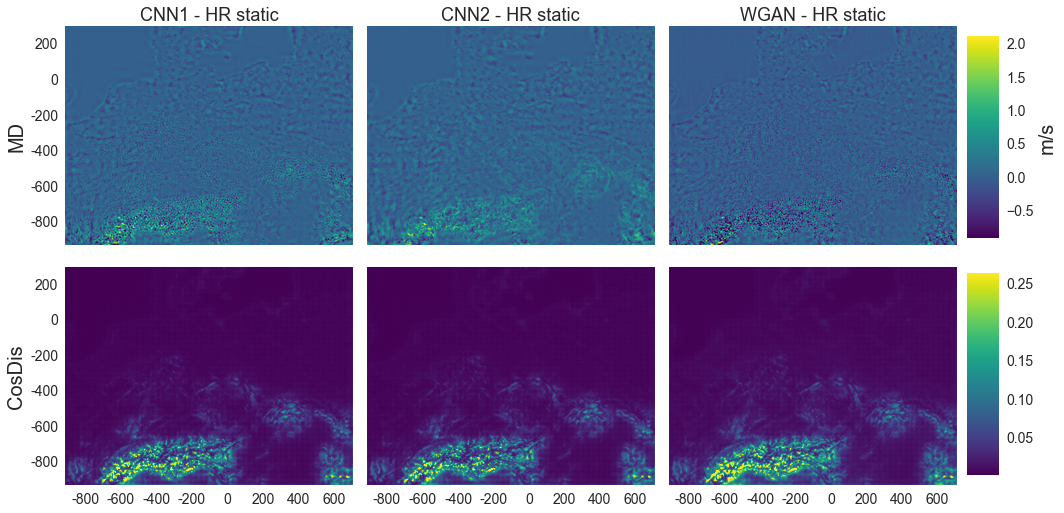

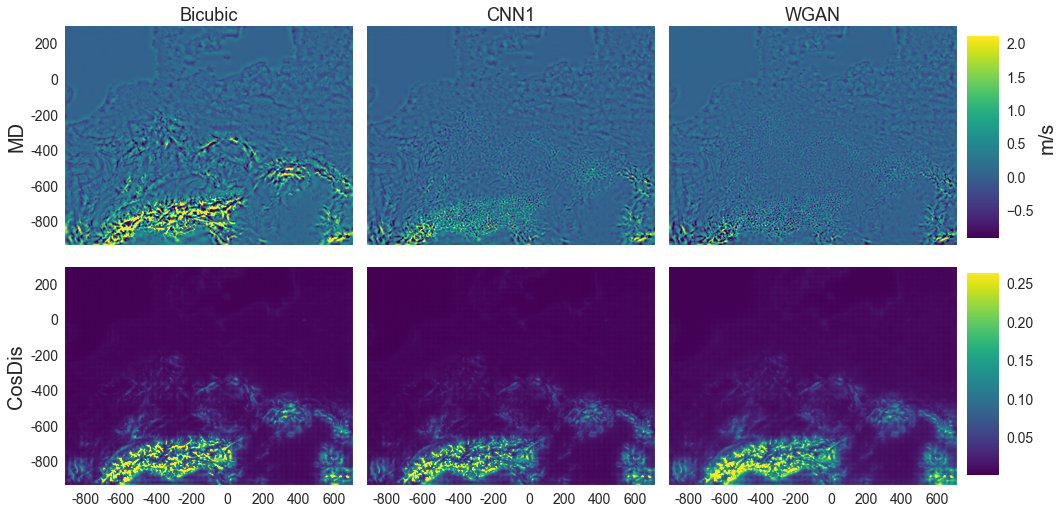

In [197]:
plot_mean_error(dn_CE,"",size=[15,7],keys=plot_keys_HR,savefig=0,dom="CE_HR",maxmin=CE_maxmin,
                xticks_loc=xticks_loc,plot_xticks=plot_xticks,
                yticks_loc=yticks_loc,plot_yticks=plot_yticks)
plot_mean_error(dn_CE,"",size=[15,7],keys=plot_keys_noHR,savefig=0,dom="CE_noHR",maxmin=CE_maxmin,
                xticks_loc=xticks_loc,plot_xticks=plot_xticks,
                yticks_loc=yticks_loc,plot_yticks=plot_yticks)

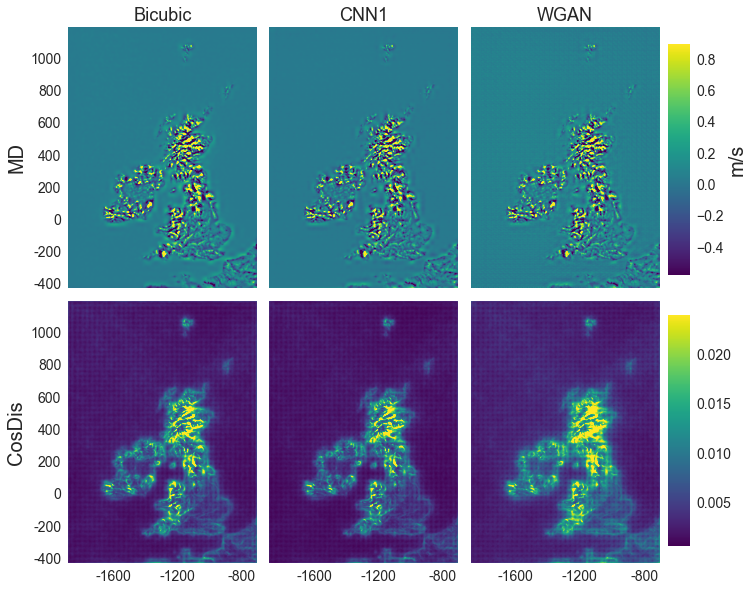

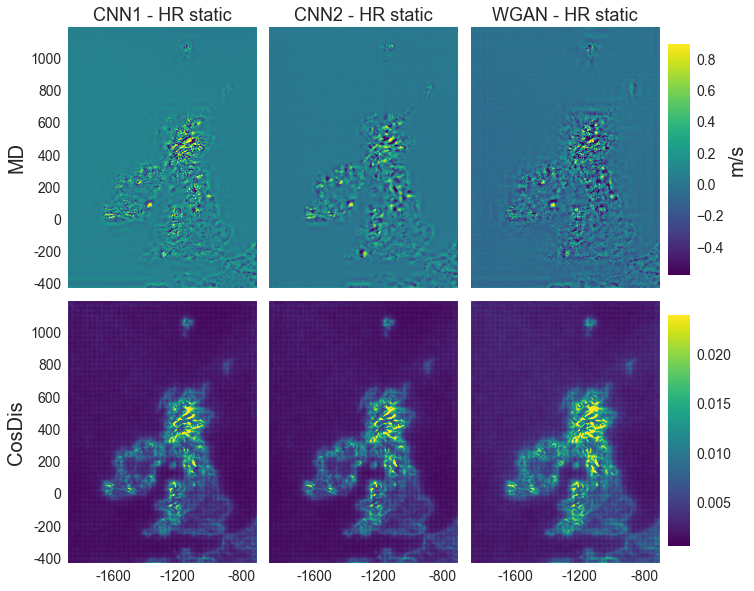

In [160]:
plot_mean_error(dn_GB,"",size=[10,8],keys=plot_keys_noHR,savefig=1,dom="GB_noHR",maxmin=GB_maxmin,                
                xticks_loc=xticks_loc_GB[1::2],plot_xticks=plot_xticks_GB[1::2],
                yticks_loc=yticks_loc_GB,plot_yticks=plot_yticks_GB)
plot_mean_error(dn_GB,"",size=[10,8],keys=plot_keys_HR,savefig=1,dom="GB_HR",maxmin=GB_maxmin,                
                xticks_loc=xticks_loc_GB[1::2],plot_xticks=plot_xticks_GB[1::2],
                yticks_loc=yticks_loc_GB,plot_yticks=plot_yticks_GB)

In [24]:
dd_CE=get_dict_and_merge(DfilesCE[-3:-1])
dd_GB=get_dict_and_merge(DfilesGB[:-1])

In [25]:
plot_keys=['CNN1 - no static', 'CNN1 - HR static', 'CNN2 - HR static', 'WGAN - no static','WGAN - HR static','Bicubic',]
plot_keys_noHR=['CNN1 - no static', 'WGAN - no static','Bicubic',]
plot_keys_HR=['CNN1 - HR static', 'CNN2 - HR static','WGAN - HR static']

In [32]:
df=pd.DataFrame()
for model in ['Bicubic','CNN1 - no static', 'CNN1 - HR static', 'CNN2 - HR static', 'WGAN - no static','WGAN - HR static']:
    df[model]=np.asarray(dd_CE[model])*2
df2latex(df.describe().iloc[1:,:],2)

In [38]:
df=pd.DataFrame()
for model in ['Bicubic','CNN1 - no static', 'CNN1 - HR static', 'CNN2 - HR static', 'WGAN - no static','WGAN - HR static']:
    df[model]=np.asarray(dd_GB[model])*2
df2latex(df.describe().iloc[1:,:],2)

\begin{tabular}{lrrrrrr}
\toprule
{} &  Bicubic &  CNN1 - no static &  CNN1 - HR static &  CNN2 - HR static &  WGAN - no static &  WGAN - HR static \\
\midrule
mean &     0.84 &              0.73 &              0.66 &              0.65 &              1.11 &              0.98 \\
std  &     0.42 &              0.38 &              0.37 &              0.37 &              0.55 &              0.56 \\
min  &     0.22 &              0.20 &              0.17 &              0.17 &              0.32 &              0.24 \\
25\%  &     0.55 &              0.47 &              0.41 &              0.40 &              0.74 &              0.59 \\
50\%  &     0.72 &              0.62 &              0.54 &              0.54 &              0.95 &              0.80 \\
75\%  &     1.02 &              0.88 &              0.79 &              0.78 &              1.32 &              1.20 \\
max  &     3.21 &              3.00 &              2.91 &              3.00 &              4.38 &              4.24 \\
\bot

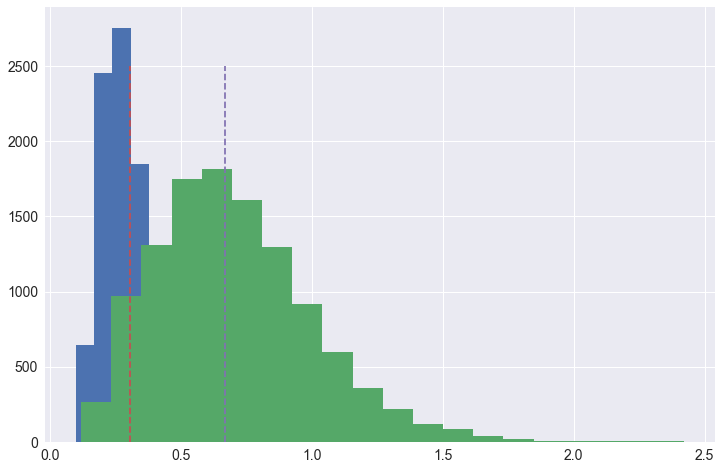

In [323]:
plt.hist(np.asarray(dd_GB["CNN1 - no static"]),bins=20)
plt.hist(np.asarray(dd_CE["CNN1 - no static"]),bins=20)
plt.plot([np.percentile(np.asarray(dd_GB["CNN1 - no static"]),50)]*2,[0,2500],"--")
plt.plot([np.percentile(np.asarray(dd_CE["CNN1 - no static"]),50)]*2,[0,2500],"--")

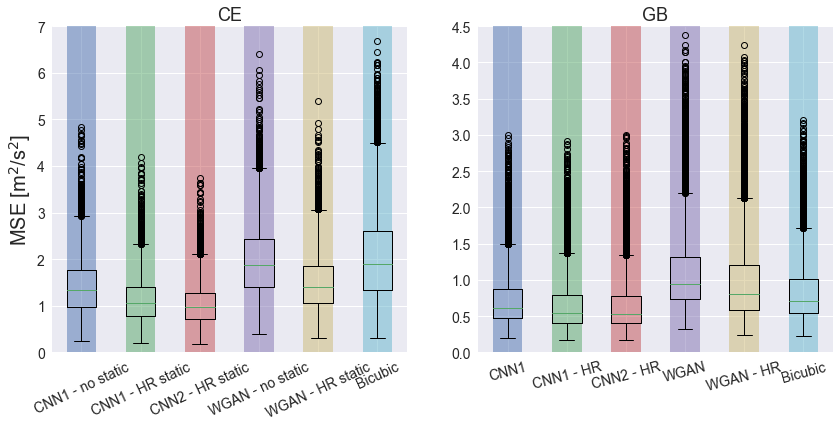

In [317]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=[14,6])
#plt.suptitle("",fontsize=16)

#ax1.plot(dd["e"],100*dd["tl_e"])
#ax1.plot(cnn_epoch_1,cnn_epoch_loss_1)
#ax1.set_xlabel("Epoch")
#ax1.set_ylabel("Normalized time per epoch")
boxdata=[]
for key in plot_keys:
    boxdata+=[2*np.array(dd_CE[key])]
_=ax1.boxplot(boxdata,labels=plot_keys)
ax1.set_ylim(0,7)

for i in range(0,len(plot_keys)):
    ax1.axvspan(i+1-0.25, i+1.25, facecolor=palette[i], alpha=0.5)
#ax1.set_xticks([])
ax1.xaxis.set_tick_params(which='both', rotation=25)
ax1.set_ylabel(r"MSE [m$^2$/s$^2$]")
ax1.set_title("CE")

boxdata=[]
for key in plot_keys:
    boxdata+=[2*np.array(dd_GB[key])]
_=ax2.boxplot(boxdata,labels=[key.replace(" static","").replace(" - no","") for key in plot_keys])
ax2.set_ylim(0,4.5)

for i in range(0,len(plot_keys)):
    ax2.axvspan(i+1-0.25, i+1.25, facecolor=palette[i], alpha=0.5)
#ax2.set_xticks([])
plt.xticks(rotation = 15)
ax2.set_title("GB")
#ax2.legend(plot_keys, loc='upper left',frameon=True)

plt.savefig('DomainErrorBox.png', dpi=200, bbox_inches='tight')


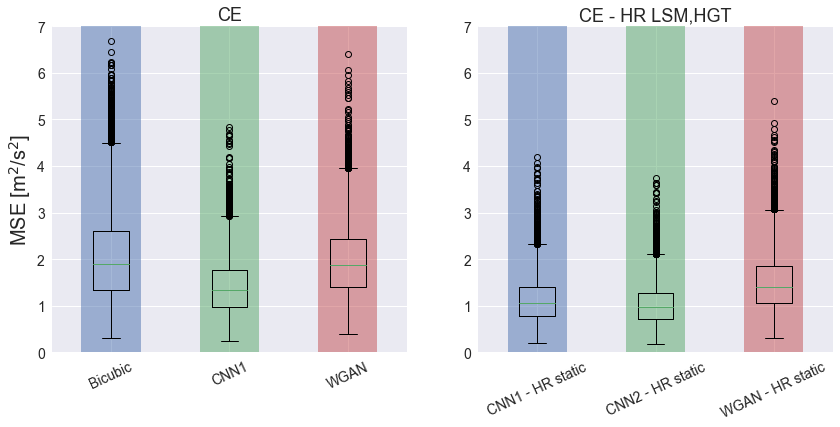

In [46]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=[14,6])
#plt.suptitle("",fontsize=16)

#ax1.plot(dd["e"],100*dd["tl_e"])
#ax1.plot(cnn_epoch_1,cnn_epoch_loss_1)
#ax1.set_xlabel("Epoch")
#ax1.set_ylabel("Normalized time per epoch")
boxdata=[]
for key in plot_keys_noHR:
    boxdata+=[2*np.array(dd_CE[key])]
_=ax1.boxplot(boxdata,labels=[key.replace(" - no static","") for key in plot_keys_noHR])
ax1.set_ylim(0,7)

for i in range(0,len(plot_keys_noHR)):
    ax1.axvspan(i+1-0.25, i+1.25, facecolor=palette[i], alpha=0.5)
#ax1.set_xticks([])
ax1.xaxis.set_tick_params(which='both', rotation=25)
ax1.set_ylabel(r"MSE [m$^2$/s$^2$]")
ax1.set_title("CE")

boxdata=[]
for key in plot_keys_HR:
    boxdata+=[2*np.array(dd_CE[key])]
_=ax2.boxplot(boxdata,labels=plot_keys_HR)
#ax2.set_ylim(0,4.5)
ax2.set_ylim(0,7)

for i in range(0,len(plot_keys_HR)):
    ax2.axvspan(i+1-0.25, i+1.25, facecolor=palette[i], alpha=0.5)
#ax2.set_xticks([])
plt.xticks(rotation = 25)
ax2.set_title("CE - HR LSM,HGT")
#ax2.legend(plot_keys, loc='upper left',frameon=True)

plt.savefig('DomainErrorBox.png', dpi=200, bbox_inches='tight')


###  Ablation study

In [19]:
def df2latex(df,Nd=3):
    print(df.to_latex(float_format="%0.{}f".format(Nd)))

In [20]:
dd_CE=get_dict_and_merge(['//smb.uni-oldenburg.de/hpc_data/thesis/data/results\\wind-20220403-215439_20220404-104804__wind-20220519-113058__wind-20220520-215250__wind-20220419-143003_20220420-182503__wind-20220413-182848__wind-20220430-180155__wind-20220429-211329-CE-DomainStat.json'])

In [21]:
dd_CE.keys()

dict_keys(['GCNN1 - no static', 'GCNN1 - HR and LR static', 'GCNN1 - HR static', 'GCNN2 - no static', 'GCNN2 - HR and LR static', 'GCNN3 - HR static', 'GCNN3 - HR and LR static', 'Bicubic'])

In [25]:
mse=[]
for key in dd_CE.keys():
    mse+=[2*np.mean(np.asarray(dd_CE[key]))]

In [27]:
mse_diff=(mse-mse[0])/mse[0]

In [36]:
df=pd.DataFrame({"mse":mse,"rel mse":mse_diff*100},index=list(dd_CE.keys())).T.iloc[:,:-1]

In [37]:
df2latex(df)

\begin{tabular}{lrrrrrrr}
\toprule
{} &  GCNN1 - no static &  GCNN1 - HR and LR static &  GCNN1 - HR static &  GCNN2 - no static &  GCNN2 - HR and LR static &  GCNN3 - HR static &  GCNN3 - HR and LR static \\
\midrule
mse     &              1.823 &                     1.573 &              1.522 &              1.819 &                     1.202 &              1.180 &                     1.200 \\
rel mse &              0.000 &                   -13.695 &            -16.499 &             -0.191 &                   -34.084 &            -35.247 &                   -34.167 \\
\bottomrule
\end{tabular}



In [33]:
def get_metric_df(d):
    df_MSE=pd.DataFrame()
    df_MBE=pd.DataFrame()
    df_MAE=pd.DataFrame()
    for id_ in d.keys():#plot_keys:
        MBE=np.asarray(d[id_]["MBE"])
        MSE=np.asarray(d[id_]["MSE"])
        #MBE=np.mean(dif,axis=(0,1,2))
        MAE=np.asarray(d[id_]["MAE"])


        df_MSE=pd.concat([df_MSE,pd.DataFrame({id_:np.mean(MSE,axis=(0,1))},index=["u","v"])],axis=1)
        df_MBE=pd.concat([df_MBE,pd.DataFrame({id_:np.mean(MBE,axis=(0,1))},index=["u","v"])],axis=1)
        df_MAE=pd.concat([df_MAE,pd.DataFrame({id_:np.mean(MAE,axis=(0,1))},index=["u","v"])],axis=1)
    return df_MSE,df_MBE,df_MAE




In [15]:
get_metric_df(dd_CE)

TypeError: list indices must be integers or slices, not str

In [49]:
#calc perf diff of two arch using static or no static
df2latex(-df_MSE.iloc[:,0:-1].diff(2,axis=1).dropna(axis=1)/df_MSE.iloc[:,0:2].values*100,1)

\begin{tabular}{lrr}
\toprule
{} &  CNN2 no static &  CNN2 with static \\
\midrule
u &             1.1 &              25.5 \\
v &            -4.7 &              31.6 \\
\bottomrule
\end{tabular}



In [52]:
df2latex(df_MSE)
df2latex(df_MAE)

\begin{tabular}{lrrrr}
\toprule
{} &  CNN1 - no static &  CNN1 - HR static &  CNN2 - HR static &  Bicubic \\
\midrule
u &             0.362 &             0.338 &             0.330 &    0.413 \\
v &             0.366 &             0.320 &             0.324 &    0.424 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
{} &  CNN1 - no static &  CNN1 - HR static &  CNN2 - HR static &  Bicubic \\
\midrule
u &             0.359 &             0.361 &             0.351 &    0.380 \\
v &             0.356 &             0.340 &             0.344 &    0.378 \\
\bottomrule
\end{tabular}



In [22]:
df2latex(pd.read_csv(files[0],index_col=0))
df2latex(pd.read_csv(files[1],index_col=0))
df2latex(pd.read_csv(files[2],index_col=0))

\begin{tabular}{lrrr}
\toprule
{} &  CNN no static &  CNN w static &  Bicubic \\
\midrule
u &          0.450 &         0.436 &    0.582 \\
v &          0.477 &         0.462 &    0.584 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  CNN no static &  CNN w static &  Bicubic \\
\midrule
u &          0.061 &         0.032 &    0.000 \\
v &          0.020 &         0.013 &   -0.000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  CNN no static &  CNN w static &  Bicubic \\
\midrule
u &          0.547 &         0.495 &    0.991 \\
v &          0.678 &         0.609 &    1.110 \\
\bottomrule
\end{tabular}



###  out_postproc dev

In [1]:
import xarray as xr
import numpy as np
#import matplotlib
#matplotlib.use('agg') #disable tk backend
import matplotlib.pyplot as plt

from glob import glob

import pandas as pd

import tensorflow as tf
#tf.disable_v2_behavior()

from scipy.interpolate import interp2d#,RBFInterpolator

In [2]:
def plot_SR_HR_data(d, path):
    keys=list(d.keys())
    
    HR=d["HR"]
    keys.remove('HR')
    if "LR" in keys:
        LR=d["LR"]
        keys.remove('LR')
    else:
        LR=downscale_image(HR,10)
    
    Ncol=len(keys)+2
    for i in range(HR.shape[0]):
        #plt.figure(figsize=(16, 8))
        fig, ax = plt.subplots(2, Ncol,figsize=[16,6],gridspec_kw = {'wspace':0.05, 'hspace':0.05, "top":0.95,"bottom":0.02})
        #plotting limits based on HR data
        vmin0, vmax0 = np.min(HR[i,:,:,0]), np.max(HR[i,:,:,0])
        vmin1, vmax1 = np.min(HR[i,:,:,1]), np.max(HR[i,:,:,1])
        
        # HR leftmost plot
        ax_=ax[0,0]
        ax_.imshow(HR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower',aspect='auto')
        ax_.set_title('HR', fontsize=12)
        ax_.set_ylabel('u', fontsize=9)
        #plt.colorbar()
        ax_.set_xticks([], [])
        ax_.set_yticks([], [])
        #plt.tight_layout()
        
        ax_=ax[1,0]
        ax_.imshow(HR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower',aspect='auto')
        ax_.set_ylabel('v', fontsize=9)
        #plt.colorbar()
        ax_.set_xticks([], [])
        ax_.set_yticks([], [])
        #plt.tight_layout()
        
        # LR rightmost plot
        ax_=ax[0,-1]
        ax_.imshow(LR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower',aspect='auto')
        ax_.set_title('LR', fontsize=12)
        #plt.colorbar()
        ax_.set_xticks([], [])
        ax_.set_yticks([], [])
        #plt.tight_layout()
        
        
        ax_=ax[1,-1]
        ax_.imshow(LR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower',aspect='auto')
        #plt.colorbar()
        ax_.set_xticks([], [])
        ax_.set_yticks([], [])
        #plt.tight_layout()
        
        # loop through comparison models
        for j,key in enumerate(keys):
            SR=d[key]

            ax_=ax[0,j+1]
            im0=ax_.imshow(SR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower',aspect='auto')
            ax_.set_title(key, fontsize=12)
            #plt.colorbar()
            ax_.set_xticks([], [])
            ax_.set_yticks([], [])
            #plt.tight_layout()

            ax_=ax[1,j+1]
            im1=ax_.imshow(SR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower',aspect='auto')
            #plt.colorbar()
            ax_.set_xticks([], [])
            ax_.set_yticks([], [])
            #plt.tight_layout()
        #plt.tight_layout()
        #fig.tight_layout()
        #fig.subplots_adjust(right=0.8)
        fig.subplots_adjust(right=0.95)
        cbar_ax0 = fig.add_axes([0.96, 0.52, 0.03, 0.4])
        fig.colorbar(im0, cax=cbar_ax0)
        cbar_ax0.set_label('m/s')
        cbar_ax1 = fig.add_axes([0.96, 0.05, 0.03, 0.4])
        fig.colorbar(im1, cax=cbar_ax1)
        plt.savefig(path+'_HRvsSRimg{0:05d}.png'.format(i), dpi=200, bbox_inches='tight')
        plt.close()




def get_bicubic_interp_SR(grid,LR_val):
    # grid: dict with south_north, west_east wrf grid info (LR and HR)
    SR_all=None
    for i in range(np.shape(LR_val)[0]):
        fu=interp2d(grid["we_lr"],grid["sn_lr"],LR_val[i,:,:,0],kind="cubic")
        fv=interp2d(grid["we_lr"],grid["sn_lr"],LR_val[i,:,:,1],kind="cubic")
        zu = fu(grid["we"], grid["sn"])
        zv = fv(grid["we"], grid["sn"])

        SR=np.stack([zu,zv],axis=-1)
        SR=SR[np.newaxis,...]
        if SR_all is None:
            SR_all=SR
        else:
            SR_all=np.concatenate([SR_all,SR],axis=0)
    return SR_all

def get_RBF_interp_SR(LR_val,xobs,xflat,N_sn,N_we):
    SR_all=None
    for i in range(np.shape(LR_val)[0]):
        uobs=np.ravel(LR_val[i,:,:,0])
        vobs=np.ravel(LR_val[i,:,:,1])

        uflat = RBFInterpolator(xobs, uobs, smoothing=0, kernel='cubic')(xflat)
        ugrid = uflat.reshape(N_sn,N_we)

        vflat = RBFInterpolator(xobs, vobs, smoothing=0, kernel='cubic')(xflat)
        vgrid = vflat.reshape(N_sn,N_we)

        SR=np.stack([ugrid,vgrid],axis=-1)
        SR=SR[np.newaxis,...]
        if SR_all is None:
            SR_all=SR
        else:
            SR_all=np.concatenate([SR_all,SR],axis=0)
    return SR_all

    
def get_test_error(out_ids,ids,HR_files,grid={},diri_out="/nfs/data/dahl0071/thesis/data/out",plot=0):
    #grid: dict storing WRF LR and HR grid info for baseline interpolators. If empty (default) no baselines calculated
    #idea to plot all on e.g. 4x1 subplot, storing SR results of all models in dict that gets updated for every HR file
    d={}#init
    for j,file in enumerate(HR_files):
        d_results={} #init
        d_results["HR"]=np.load(file)
        #timestamp=file.split("/")[-1].split(".")[0][5:]
        timestamp=file.split("\\")[-1].split(".")[0]
        print("starting on "+timestamp)
        for i, out_id in enumerate(out_ids):
            id_=ids[i]
            out_path='/'.join([diri_out, out_id])
            SR_file="/".join([out_path,timestamp+"_dataSR.npy"])   
            d_results[id_]=np.load(SR_file)

            dif=d_results[id_]-d_results["HR"]
            if out_id not in d.keys():
                d[id_]=dif
            else:
                d[id_]=np.concatenate([d[id_],dif],axis=0)
        # baseline interpolators
        if bool(grid):
            print("Doing baselines")
            d_results["LR"]=downscale_image(d_results["HR"],10)
            
            #bicubic
            d_results["Bicubic"]=get_bicubic_interp_SR(grid,d_results["LR"])
            dif=d_results["Bicubic"]-d_results["HR"]
            if "Bicubic" not in d.keys():
                d["Bicubic"]=dif
            else:
                d["Bicubic"]=np.concatenate([d["Bicubic"],dif],axis=0)
            
            ### RBF
#             xobs=np.meshgrid(grid["we_lr"],grid["sn_lr"])
#             xgrid=np.meshgrid(grid["we"],grid["sn"])
#             xflat = np.reshape(xgrid,(2, -1)).T
#             xobs = np.reshape(xobs,(2, -1)).T
#             N_sn=len(grid["sn"])
#             N_we=len(grid["we"])
            
#             SR=get_RBF_interp_SR(LR_val,xobs,xflat,N_sn,N_we)
#             dif=SR-HR
#             if "RBF" not in d.keys():
#                 d["RBF"]=dif
#             else:
#                 d["RBF"]=np.concatenate([d["RBF"],dif],axis=0)

        if plot and j%10==0: #plot every 10th day
            print("plotting ...")
            image_path="/".join([out_path,"imgs",timestamp])
            plot_SR_HR_data(d_results,image_path)
            

        print(timestamp+" done")
        
    return d



In [3]:
def downscale_image(x, K):
    tf.reset_default_graph()

    if x.ndim == 3:
        x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))

    x_in = tf.placeholder(tf.float64, [None, x.shape[1], x.shape[2], x.shape[3]])
    weight = tf.constant(1.0/K**2, shape=[K, K, x.shape[3], 1], dtype=tf.float64)
    p_filt=tf.eye(2,batch_shape=[1,1],  dtype=tf.float64)
    downscaled = tf.nn.separable_conv2d(x_in,depthwise_filter=weight,pointwise_filter=p_filt, strides=[1, K, K, 1], padding='SAME')
    with tf.Session() as sess:
        ds_out = sess.run(downscaled, feed_dict={x_in: x})
    return ds_out

In [4]:
glob("//smb.uni-oldenburg.de/hpc_data/thesis/data/out/*")

['//smb.uni-oldenburg.de/hpc_data/thesis/data/out\\trained-gan1_20220314-130627',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/out\\wind-20220306-032715_20220314-124138',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/out\\wind-20220309-191837',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/out\\wind-20220314-174433_20220320-160410',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/out\\wind-20220403-215439_20220404-104804',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/out\\wind-20220404-011634_20220404-135918',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/out\\wind_lr-mr_wind-20220314-122018']

In [4]:
diri_in='/'.join(["//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017"])

In [5]:
HR_files=glob(diri_in+"/*.npy")
HR_files

['//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017\\P-CE-2017-2017-03-10.npy',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017\\P-CE-2017-2017-02-05.npy',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017\\P-CE-2017-2017-01-10.npy',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017\\P-CE-2017-2017-03-09.npy',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017\\P-CE-2017-2017-01-19.npy',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017\\P-CE-2017-2017-09-30.npy',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017\\P-CE-2017-2017-01-21.npy',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017\\P-CE-2017-2017-05-03.npy',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017\\P-CE-2017-2017-04-08.npy',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017\\P-CE-2017-2017-07-19.npy',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017\\P-CE-2017-2017-10-09.npy',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017\\P-CE-2017-2017-07-0

In [7]:
out_ids=["wind-20220403-215439_20220404-104804",
        "wind-20220404-011634_20220404-135918"]
ids=["CNN no static","CNN w static"]

ncfile='//smb.uni-oldenburg.de/hpc_data/NEWA_nc/P-CE-2018-2018-03-01.nc'

ds=xr.open_dataset(ncfile)
ds=ds.isel(south_north=slice(2,412))
LR=ds.WS.coarsen(south_north=10,west_east=10).mean()
grid_d={}#init
grid_d["sn_lr"]=LR.south_north.values
grid_d["we_lr"]=LR.west_east.values
grid_d["sn"]=ds.south_north.values
grid_d["we"]=ds.west_east.values
#ds.close()



In [8]:
d=get_test_error(out_ids,ids,HR_files[0:10],grid=grid_d,diri_out="//smb.uni-oldenburg.de/hpc_data/thesis/data/out",plot=0)

starting on P-CE-2017-2017-03-10
Doing baselines
P-CE-2017-2017-03-10 done
starting on P-CE-2017-2017-02-05
Doing baselines
P-CE-2017-2017-02-05 done
starting on P-CE-2017-2017-01-10
Doing baselines
P-CE-2017-2017-01-10 done
starting on P-CE-2017-2017-03-09
Doing baselines
P-CE-2017-2017-03-09 done
starting on P-CE-2017-2017-01-19
Doing baselines
P-CE-2017-2017-01-19 done
starting on P-CE-2017-2017-09-30
Doing baselines
P-CE-2017-2017-09-30 done
starting on P-CE-2017-2017-01-21
Doing baselines
P-CE-2017-2017-01-21 done
starting on P-CE-2017-2017-05-03
Doing baselines
P-CE-2017-2017-05-03 done
starting on P-CE-2017-2017-04-08
Doing baselines
P-CE-2017-2017-04-08 done
starting on P-CE-2017-2017-07-19
Doing baselines
P-CE-2017-2017-07-19 done


In [2]:
import json
from NumpyEncoder import NumpyEncoder

In [3]:
for id_ in d.keys():
    dif=d[id_]
    d[id_]={}
    d[id_]["MSE"]=np.mean(np.power(dif,2),axis=0)
    d[id_]["MBE"]=np.mean(dif,axis=0)
    d[id_]["MAE"]=np.mean(np.abs(dif),axis=0)
    

NameError: name 'd' is not defined

In [17]:
with open('data.json', 'w') as fp:
    json.dump(d, fp,cls=NumpyEncoder)

In [20]:
with open('data.json') as fp:
    dd = json.load(fp)
#a_restored = np.asarray()

In [25]:
np.mean(dd["Bicubic"]["MSE"],axis=(0,1))

array([0.94157272, 1.06150133])

In [35]:
np.asarray(dd["Bicubic"]["MBE"])

array([[[ 3.73399666e-01,  1.49612935e-01],
        [ 9.01327048e-02,  1.45020020e-01],
        [-2.33934497e-01,  2.03497946e-01],
        ...,
        [ 1.25018901e-01, -1.36942915e-01],
        [ 2.71937974e-01, -1.22959013e-01],
        [ 3.66293945e-01, -1.79006215e-01]],

       [[ 3.51072839e-01, -2.48438408e-01],
        [ 1.00277695e-01, -2.01263829e-01],
        [-1.80555967e-01, -1.29208392e-01],
        ...,
        [ 1.64414099e-01,  7.92213583e-04],
        [ 3.52952909e-01,  1.62938223e-02],
        [ 4.17862868e-01, -3.57548155e-02]],

       [[ 3.12877360e-01, -5.84783410e-01],
        [ 9.25531756e-02, -5.08399857e-01],
        [-1.59471771e-01, -4.27507037e-01],
        ...,
        [ 1.33849871e-01,  1.30584004e-01],
        [ 2.49619804e-01,  1.74589346e-01],
        [ 3.05767220e-01,  1.28877309e-01]],

       ...,

       [[ 3.27737205e-02, -1.94979022e-01],
        [ 1.88354065e-03, -1.65393444e-01],
        [-2.66437195e-02, -1.36496452e-01],
        ...,
     

### OLD, supports RBF

In [ ]:
#USE MYDEEPENV
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

import pandas as pd

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from scipy.interpolate import griddata,interp1d,interp2d

def downscale_image(x, K):
    tf.reset_default_graph()

    if x.ndim == 3:
        x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))

    x_in = tf.placeholder(tf.float64, [None, x.shape[1], x.shape[2], x.shape[3]])
    weight = tf.constant(1.0/K**2, shape=[K, K, x.shape[3], 1], dtype=tf.float64)
    p_filt=tf.eye(2,batch_shape=[1,1],  dtype=tf.float64)
    downscaled = tf.nn.separable_conv2d(x_in,depthwise_filter=weight,pointwise_filter=p_filt, strides=[1, K, K, 1], padding='SAME')
    with tf.Session() as sess:
        ds_out = sess.run(downscaled, feed_dict={x_in: x})
    return ds_out

In [3]:
def plot_SR_HR_data(HR, SR, path):
    for i in range(HR.shape[0]):
        vmin0, vmax0 = np.min(SR[i,:,:,0]), np.max(SR[i,:,:,0])
        vmin1, vmax1 = np.min(SR[i,:,:,1]), np.max(SR[i,:,:,1])

        plt.figure(figsize=(12, 12))
        
        plt.subplot(221)
        plt.imshow(HR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
        plt.title('HR 0', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])
        
        plt.subplot(223)
        plt.imshow(HR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
        plt.title('HR 1', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])
        
        plt.subplot(222)
        plt.imshow(SR[i, :, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
        plt.title('SR 0 Output', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])
        
        plt.subplot(224)
        plt.imshow(SR[i, :, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
        plt.title('SR 1 Output', fontsize=9)
        plt.colorbar()
        plt.xticks([], [])
        plt.yticks([], [])

        plt.savefig(path+'_HRvsSRimg{0:05d}.png'.format(i), dpi=200, bbox_inches='tight')
        plt.close()



In [4]:
def plot_SR_HR_mean_data(diff,path):
    
    RMSE=np.sqrt(np.mean(np.power(dif,2),axis=(0)))
    MBE=np.mean(dif,axis=0)
    
    vmin0, vmax0 = np.min(MBE[:,:,0]), np.max(MBE[:,:,0])
    vmin1, vmax1 = np.min(MBE[:,:,1]), np.max(MBE[:,:,1])

    plt.figure(figsize=(12, 12))

    plt.subplot(221)
    plt.imshow(MBE[:, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
    plt.title('u MBE [m/s]', fontsize=9)
    plt.colorbar()
    plt.xticks([], [])
    plt.yticks([], [])

    plt.subplot(223)
    plt.imshow(MBE[:, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
    plt.title('v MBE [m/s]', fontsize=9)
    plt.colorbar()
    plt.xticks([], [])
    plt.yticks([], [])
    
    vmin0, vmax0 = np.min(RMSE[:,:,0]), np.max(RMSE[:,:,0])
    vmin1, vmax1 = np.min(RMSE[:,:,1]), np.max(RMSE[:,:,1])
    
    plt.subplot(222)
    plt.imshow(RMSE[:, :, 0], vmin=vmin0, vmax=vmax0, cmap='viridis', origin='lower')
    plt.title('u RMSE [m/s]', fontsize=9)
    plt.colorbar()
    plt.xticks([], [])
    plt.yticks([], [])

    plt.subplot(224)
    plt.imshow(RMSE[:, :, 1], vmin=vmin1, vmax=vmax1, cmap='viridis', origin='lower')
    plt.title('v RMSE [m/s]', fontsize=9)
    plt.colorbar()
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.savefig(path+'/MBE_RMSE.png', dpi=200, bbox_inches='tight')
    plt.close()


In [5]:
def get_test_error(SR_files,plot_path,diri_in,plot=0):
    #diri_in
    dif_all=None
    for file in SR_files:
        SR=np.load(file)
        timestamp=file.split("\\")[1].split("_")[0]
        HR_file="/".join([diri_in,timestamp+".npy"])   
        HR=np.load(HR_file)

        if plot:
            image_path="/".join([plot_path,timestamp])
            plot_SR_HR_data(HR,SR,image_path)

        dif=SR-HR
        if dif_all is None:
            dif_all=dif
        else:
            dif_all=np.concatenate([dif_all,dif],axis=0)

        print(timestamp+" done")

    if plot:
        plot_SR_HR_mean_data(dif_all,plot_path)
        
    return dif_all

In [19]:
def get_test_error2(out_ids,ids,HR_files,grid={},diri_out="//smb.uni-oldenburg.de/hpc_data/thesis/data/out",plot=0):
    #diri_in
    d={}#init
    for file in HR_files:
        HR=np.load(file)
        timestamp=file.split("\\")[1].split(".")[0]
        for i, out_id in enumerate(out_ids):
            out_path='/'.join([diri_out, out_id])
            SR_file="/".join([out_path,timestamp+"_dataSR.npy"])   
            SR=np.load(SR_file)
            if plot:
                image_path="/".join([out_path,"imgs",timestamp])
                plot_SR_HR_data(HR,SR,image_path)

            dif=SR-HR
            if out_id not in d.keys():
                d[ids[i]]=dif
            else:
                d[ids[i]]=np.concatenate([d[ids[i]],dif],axis=0)

        print(timestamp+" done")

    if plot:
        for key in d.keys:
            plot_path="/".join([diri_out, key,"imgs"])
            plot_SR_HR_mean_data(d[key],plot_path)
        
    return d

In [15]:
bool({})

False

In [6]:
def get_test_error_bicupic(SR_files,plot_path,diri_in,nc_file,plot=0):
    #diri_in
    ds=xr.open_dataset(nc_file)
    ds=ds.isel(south_north=slice(0,410))
    LR=ds.WS.coarsen(south_north=10,west_east=10).mean()
    sn_lr=LR.south_north.values
    we_lr=LR.west_east.values
    sn=ds.south_north.values
    we=ds.west_east.values
    ds.close()
    
    dif_all=None
    for file in SR_files:
        #SR=np.load(file)
        timestamp=file.split("\\")[1].split("_")[0]
        HR_file="/".join([diri_in,timestamp+".npy"])   
        HR=np.load(HR_file)
        
        LR_val=downscale_image(HR,10)
        

#         if plot:
#             image_path="/".join([plot_path,timestamp])
#             plot_SR_HR_data(HR,SR,image_path)
    
        for i in range(np.shape(LR_val)[0]):
            fu=interp2d(we_lr,sn_lr,LR_val[i,:,:,0],kind="cubic")
            fv=interp2d(we_lr,sn_lr,LR_val[i,:,:,1],kind="cubic")
            zu = fu(we, sn)
            zv = fv(we, sn)
        
            SR=np.stack([zu,zv],axis=-1)
            dif=SR-HR[i,:,:,:]
            dif=dif[np.newaxis,...]
            if dif_all is None:
                dif_all=dif
            else:
                dif_all=np.concatenate([dif_all,dif],axis=0)

        print(timestamp+" done")

    if plot:
        plot_SR_HR_mean_data(dif_all,plot_path)
    

    return dif_all

def get_test_error_RBF(SR_files,plot_path,diri_in,nc_file,plot=0):
    #diri_in
    ds=xr.open_dataset(nc_file)
    ds=ds.isel(south_north=slice(0,410))
    LR=ds.WS.coarsen(south_north=10,west_east=10).mean()
    sn_lr=LR.south_north.values
    we_lr=LR.west_east.values
    sn=ds.south_north.values
    we=ds.west_east.values
    ds.close()
    
    xobs=np.meshgrid(we_lr,sn_lr)
    xgrid=np.meshgrid(we,sn)
    xflat = np.reshape(xgrid,(2, -1)).T
    xobs = np.reshape(xobs,(2, -1)).T
    
    N_sn=len(sn)
    N_we=len(we)
    
    dif_all=None
    for file in SR_files:
        timestamp=file.split("\\")[1].split("_")[0]
        HR_file="/".join([diri_in,timestamp+".npy"])   
        HR=np.load(HR_file)
        
        LR_val=downscale_image(HR,10)
        

#         if plot:
#             image_path="/".join([plot_path,timestamp])
#             plot_SR_HR_data(HR,SR,image_path)
    
        for i in range(np.shape(LR_val)[0]):
            uobs=np.ravel(LR_val[i,:,:,0])
            vobs=np.ravel(LR_val[i,:,:,1])

            uflat = RBFInterpolator(xobs, uobs, smoothing=0, kernel='cubic')(xflat)
            ugrid = uflat.reshape(N_sn,N_we)

            vflat = RBFInterpolator(xobs, vobs, smoothing=0, kernel='cubic')(xflat)
            vgrid = vflat.reshape(N_sn,N_we)

            SR=np.stack([ugrid,vgrid],axis=-1)
            dif=SR-HR[i,:,:,:]
            dif=dif[np.newaxis,...]
            if dif_all is None:
                dif_all=dif
            else:
                dif_all=np.concatenate([dif_all,dif],axis=0)

        print(timestamp+" done")

    if plot:
        plot_SR_HR_mean_data(dif_all,plot_path)
    

    return dif_all

### Experiment 2

In [21]:
diri_in='/'.join(["//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017"])

HR_files=glob(diri_in+"/*.npy")

out_ids=["wind-20220403-215439_20220404-104804",
        "wind-20220404-011634_20220404-135918"]
ids=["CNN no static","CNN w static"]

d=get_test_error2(out_ids,ids,HR_files)


P-CE-2017-2017-03-10 done
P-CE-2017-2017-02-05 done
P-CE-2017-2017-01-10 done
P-CE-2017-2017-03-09 done
P-CE-2017-2017-01-19 done
P-CE-2017-2017-09-30 done
P-CE-2017-2017-01-21 done
P-CE-2017-2017-05-03 done
P-CE-2017-2017-04-08 done
P-CE-2017-2017-07-19 done
P-CE-2017-2017-10-09 done
P-CE-2017-2017-07-05 done
P-CE-2017-2017-09-19 done
P-CE-2017-2017-08-10 done
P-CE-2017-2017-08-03 done
P-CE-2017-2017-12-02 done
P-CE-2017-2017-06-05 done
P-CE-2017-2017-08-24 done
P-CE-2017-2017-10-15 done
P-CE-2017-2017-04-07 done
P-CE-2017-2017-12-03 done
P-CE-2017-2017-10-02 done
P-CE-2017-2017-12-12 done
P-CE-2017-2017-06-29 done
P-CE-2017-2017-04-16 done
P-CE-2017-2017-12-30 done
P-CE-2017-2017-08-15 done
P-CE-2017-2017-03-24 done
P-CE-2017-2017-06-07 done
P-CE-2017-2017-12-25 done
P-CE-2017-2017-08-02 done
P-CE-2017-2017-08-18 done
P-CE-2017-2017-09-16 done
P-CE-2017-2017-10-31 done
P-CE-2017-2017-12-20 done
P-CE-2017-2017-06-09 done
P-CE-2017-2017-02-04 done
P-CE-2017-2017-05-15 done
P-CE-2017-20

P-CE-2017-2017-05-24 done
P-CE-2017-2017-02-21 done
P-CE-2017-2017-03-01 done
P-CE-2017-2017-05-19 done
P-CE-2017-2017-09-20 done
P-CE-2017-2017-03-16 done
P-CE-2017-2017-02-08 done
P-CE-2017-2017-05-10 done
P-CE-2017-2017-07-22 done
P-CE-2017-2017-01-27 done
P-CE-2017-2017-07-16 done
P-CE-2017-2017-07-12 done
P-CE-2017-2017-02-25 done
P-CE-2017-2017-08-08 done
P-CE-2017-2017-03-31 done
P-CE-2017-2017-01-09 done
P-CE-2017-2017-06-13 done
P-CE-2017-2017-06-19 done
P-CE-2017-2017-08-26 done
P-CE-2017-2017-07-02 done
P-CE-2017-2017-01-01 done
P-CE-2017-2017-05-20 done
P-CE-2017-2017-11-03 done
P-CE-2017-2017-05-13 done
P-CE-2017-2017-12-29 done
P-CE-2017-2017-07-21 done
P-CE-2017-2017-10-18 done
P-CE-2017-2017-02-23 done


FileNotFoundError: [Errno 2] No such file or directory: '//smb.uni-oldenburg.de/hpc_data/thesis/data/out/wind-20220404-011634_20220404-135918/P-CE-2017-2017-11-01_dataSR.npy'

In [ ]:
df_MSE=pd.DataFrame()
df_MBE=pd.DataFrame()
df_MAE=pd.DataFrame()
for id_ in enumerate(d.keys):#"trained-gan1_20220314-130627"
    dif=d[id_]
    MSE=np.mean(np.power(dif,2),axis=(0,1,2))
    MBE=np.mean(dif,axis=(0,1,2))
    MAE=np.mean(np.abs(dif),axis=(0,1,2))
    
    df_MSE=pd.concat([df_MSE,pd.DataFrame({id_:MSE},index=["u","v"])],axis=1)
    df_MBE=pd.concat([df_MBE,pd.DataFrame({id_:MBE},index=["u","v"])],axis=1)
    df_MAE=pd.concat([df_MAE,pd.DataFrame({id_:MAE},index=["u","v"])],axis=1)


In [15]:
diri_in='/'.join(["//smb.uni-oldenburg.de/hpc_data/thesis/data/test/2017"])

out_ids=["wind-20220403-215439_20220404-104804",
        "wind-20220404-011634_20220404-135918"]
ids=["CNN no static","CNN w static"]

df_MSE=pd.DataFrame()
df_MBE=pd.DataFrame()
df_MAE=pd.DataFrame()
for i,out_id in enumerate(out_ids):#"trained-gan1_20220314-130627"
    diri_out='/'.join(["//smb.uni-oldenburg.de/hpc_data/thesis/data/out", out_id])
    #HR_files=glob(diri_in+"/*.npy")
    SR_files=glob(diri_out+"/*.npy")
    plot_path="/".join([diri_out,"imgs"])
    dif=get_test_error(SR_files,plot_path,diri_in)
    MSE=np.mean(np.power(dif,2),axis=(0,1,2))
    MBE=np.mean(dif,axis=(0,1,2))
    MAE=np.mean(np.abs(dif),axis=(0,1,2))
    
    df_MSE=pd.concat([df_MSE,pd.DataFrame({ids[i]:MSE},index=["u","v"])],axis=1)
    df_MBE=pd.concat([df_MBE,pd.DataFrame({ids[i]:MBE},index=["u","v"])],axis=1)
    df_MAE=pd.concat([df_MAE,pd.DataFrame({ids[i]:MAE},index=["u","v"])],axis=1)



['//smb.uni-oldenburg.de/hpc_data/thesis/data/out/wind-20220403-215439_20220404-104804\\P-CE-2017-2017-01-01_dataSR.npy', '//smb.uni-oldenburg.de/hpc_data/thesis/data/out/wind-20220403-215439_20220404-104804\\P-CE-2017-2017-01-02_dataSR.npy', '//smb.uni-oldenburg.de/hpc_data/thesis/data/out/wind-20220403-215439_20220404-104804\\P-CE-2017-2017-01-03_dataSR.npy', '//smb.uni-oldenburg.de/hpc_data/thesis/data/out/wind-20220403-215439_20220404-104804\\P-CE-2017-2017-01-04_dataSR.npy', '//smb.uni-oldenburg.de/hpc_data/thesis/data/out/wind-20220403-215439_20220404-104804\\P-CE-2017-2017-01-05_dataSR.npy', '//smb.uni-oldenburg.de/hpc_data/thesis/data/out/wind-20220403-215439_20220404-104804\\P-CE-2017-2017-01-06_dataSR.npy', '//smb.uni-oldenburg.de/hpc_data/thesis/data/out/wind-20220403-215439_20220404-104804\\P-CE-2017-2017-01-08_dataSR.npy', '//smb.uni-oldenburg.de/hpc_data/thesis/data/out/wind-20220403-215439_20220404-104804\\P-CE-2017-2017-01-09_dataSR.npy', '//smb.uni-oldenburg.de/hpc_dat

P-CE-2017-2017-01-01 done
P-CE-2017-2017-01-02 done
P-CE-2017-2017-01-03 done
P-CE-2017-2017-01-04 done
P-CE-2017-2017-01-05 done
P-CE-2017-2017-01-06 done
P-CE-2017-2017-01-08 done
P-CE-2017-2017-01-09 done
P-CE-2017-2017-01-10 done
P-CE-2017-2017-01-11 done
P-CE-2017-2017-01-12 done
P-CE-2017-2017-01-13 done
P-CE-2017-2017-01-14 done
P-CE-2017-2017-01-15 done
P-CE-2017-2017-01-16 done
P-CE-2017-2017-01-17 done
P-CE-2017-2017-01-18 done
P-CE-2017-2017-01-19 done
P-CE-2017-2017-01-20 done
P-CE-2017-2017-01-21 done
P-CE-2017-2017-01-22 done
P-CE-2017-2017-01-23 done
P-CE-2017-2017-01-24 done
P-CE-2017-2017-01-25 done
P-CE-2017-2017-01-26 done
P-CE-2017-2017-01-27 done
P-CE-2017-2017-01-28 done
P-CE-2017-2017-01-29 done
P-CE-2017-2017-01-30 done
P-CE-2017-2017-01-31 done
P-CE-2017-2017-02-01 done
P-CE-2017-2017-02-02 done
P-CE-2017-2017-02-03 done
P-CE-2017-2017-02-04 done
P-CE-2017-2017-02-05 done
P-CE-2017-2017-02-06 done
P-CE-2017-2017-02-07 done
P-CE-2017-2017-02-08 done
P-CE-2017-20

OSError: [Errno 22] Invalid argument

In [18]:
np.load('/'.join(["//smb.uni-oldenburg.de/hpc_data/thesis/data/out", "wind-20220403-215439_20220404-104804","P-CE-2017-2017-06-14_dataSR.npy"]))

array([[[[-2.61816717, -0.38811802],
         [-2.53984598, -0.45733903],
         [-2.51930842, -0.28033179],
         ...,
         [ 0.98791119, -4.60536929],
         [ 1.07721397, -4.34324355],
         [ 1.2545598 , -4.8894607 ]],

        [[-2.47453788, -0.80581349],
         [-2.45860761, -0.51534444],
         [-2.52998175, -0.40154391],
         ...,
         [ 1.09290442, -4.32310811],
         [ 0.69650721, -4.73355268],
         [ 0.80400727, -3.44264664]],

        [[-2.41027255, -0.54589088],
         [-2.49633564, -0.54915433],
         [-2.4366176 , -0.39481641],
         ...,
         [ 1.1520139 , -4.52827246],
         [ 1.08715576, -3.98477865],
         [-0.04987494, -4.52440458]],

        ...,

        [[ 9.96942859,  2.46565251],
         [10.04300792,  2.33596652],
         [ 9.9939115 ,  2.40531919],
         ...,
         [ 6.90195991, -2.32027165],
         [ 6.91110951, -2.32138693],
         [ 6.91649241, -2.25782913]],

        [[10.01164789,  2.50510938

In [ ]:
nc_files=glob("//smb.uni-oldenburg.de/hpc_data/NEWA_nc/*.nc")
nc_files

In [ ]:
#baselines
dif=get_test_error_base(SR_files,plot_path,diri_in,nc_files[0])

MSE=np.mean(np.power(dif,2),axis=(0,1,2))
MBE=np.mean(dif,axis=(0,1,2))
MAE=np.mean(np.abs(dif),axis=(0,1,2))

df_MSE=pd.concat([df_MSE,pd.DataFrame({"Bicubic":MSE},index=["u","v"])],axis=1)
df_MBE=pd.concat([df_MBE,pd.DataFrame({"Bicubic":MBE},index=["u","v"])],axis=1)
df_MAE=pd.concat([df_MAE,pd.DataFrame({"Bicubic":MAE},index=["u","v"])],axis=1)

dif=get_test_error_RBF(SR_files,plot_path,diri_in,nc_files[0])

MSE=np.mean(np.power(dif,2),axis=(0,1,2))
MBE=np.mean(dif,axis=(0,1,2))
MAE=np.mean(np.abs(dif),axis=(0,1,2))

df_MSE=pd.concat([df_MSE,pd.DataFrame({"RBF":MSE},index=["u","v"])],axis=1)
df_MBE=pd.concat([df_MBE,pd.DataFrame({"RBF":MBE},index=["u","v"])],axis=1)
df_MAE=pd.concat([df_MAE,pd.DataFrame({"RBF":MAE},index=["u","v"])],axis=1)

###  Baseline testing

In [7]:
diri_in='/'.join(["//smb.uni-oldenburg.de/hpc_data/thesis/data/test"])
HR_files=glob(diri_in+"/*.npy")
HR_files

['//smb.uni-oldenburg.de/hpc_data/thesis/data/test\\P-CE-2017-2017-01-01.npy',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/test\\P-CE-2017-2017-04-01.npy',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/test\\P-CE-2017-2017-07-01.npy',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/test\\P-CE-2017-2017-10-01.npy']

In [8]:
nc_files=glob("//smb.uni-oldenburg.de/hpc_data/NEWA_nc/*.nc")
nc_files

['//smb.uni-oldenburg.de/hpc_data/NEWA_nc\\P-CE-2018-2018-03-01.nc',
 '//smb.uni-oldenburg.de/hpc_data/NEWA_nc\\P-CE-2018-2018-06-01.nc',
 '//smb.uni-oldenburg.de/hpc_data/NEWA_nc\\P-CE-2018-2018-09-01.nc',
 '//smb.uni-oldenburg.de/hpc_data/NEWA_nc\\P-CE-2018-2018-12-17.nc',
 '//smb.uni-oldenburg.de/hpc_data/NEWA_nc\\P-GB-2018-2018-12-17.nc']

In [9]:
ds=xr.open_dataset(nc_files[0])
ds=ds.isel(south_north=slice(0,410))
LR=ds.WS.coarsen(south_north=10,west_east=10).mean()
LR_XLAT=LR.XLAT.values
LR_XLON=LR.XLON.values
XLAT=ds.XLAT
XLON=ds.XLON

In [12]:
HR=np.load(HR_files[0])
        
LR_val=downscale_image(HR,10)

In [13]:
from scipy.interpolate import griddata,interp1d,interp2d

### RBF

In [26]:
xobs=np.meshgrid(LR.west_east.values,LR.south_north.values)
xgrid=np.meshgrid(ds.west_east.values,ds.south_north.values)
xflat = np.reshape(xgrid,(2, -1)).T
xobs = np.reshape(xobs,(2, -1)).T

In [41]:
dif_all=None

xobs=np.meshgrid(LR.west_east.values,LR.south_north.values)
xgrid=np.meshgrid(ds.west_east.values,ds.south_north.values)
xflat = np.reshape(xgrid,(2, -1)).T
xobs = np.reshape(xobs,(2, -1)).T

N_sn=len(ds.south_north.values)
N_we=len(ds.west_east.values)

for HR_file in HR_files:
    HR=np.load(HR_file)
            
    LR_val=downscale_image(HR,10)
    
    for i in range(np.shape(LR_val)[0]):
        uobs=np.ravel(LR_val[i,:,:,0])
        vobs=np.ravel(LR_val[i,:,:,1])
    
        uflat = RBFInterpolator(xobs, uobs, smoothing=0, kernel='cubic')(xflat)
        ugrid = uflat.reshape(N_sn,N_we)
        
        vflat = RBFInterpolator(xobs, vobs, smoothing=0, kernel='cubic')(xflat)
        vgrid = vflat.reshape(N_sn,N_we)
        
        SR=np.stack([ugrid,vgrid],axis=-1)
        dif=SR-HR[i,:,:,:]
        dif=dif[np.newaxis,...]
        if dif_all is None:
            dif_all=dif
        else:
            dif_all=np.concatenate([dif_all,dif],axis=0)
        
    print(HR_file)
    print(np.nanmean((dif_all)**2,axis=(0,1,2)))

//smb.uni-oldenburg.de/hpc_data/thesis/data/test\P-CE-2017-2017-01-01.npy
[1.16817414 0.75317555]
//smb.uni-oldenburg.de/hpc_data/thesis/data/test\P-CE-2017-2017-04-01.npy
[1.00251404 1.0764669 ]
//smb.uni-oldenburg.de/hpc_data/thesis/data/test\P-CE-2017-2017-07-01.npy
[0.97532914 0.98456464]
//smb.uni-oldenburg.de/hpc_data/thesis/data/test\P-CE-2017-2017-10-01.npy
[0.84911491 0.88770962]


In [42]:
np.nanmean((dif_all)**2,axis=(0,1,2))

array([0.84911491, 0.88770962])

###  griddata
Sets external points as NA

In [81]:
lats=np.ravel(LR_XLAT)
lons=np.ravel(LR_XLON)
points=[[lats[i],lons[i]] for i in range(len(lats))]

In [247]:
dif_all=None
for HR_file in HR_files:
    HR=np.load(HR_file)
            
    LR_val=downscale_image(HR,10)
    
    for i in range(np.shape(LR_val)[0]):
        u=griddata(points, np.ravel(LR_val[i,:,:,0]), (ds.XLAT.values, ds.XLON.values), method='cubic')
        v=griddata(points, np.ravel(LR_val[i,:,:,1]), (ds.XLAT.values, ds.XLON.values), method='cubic')
        
        SR=np.stack([u,v],axis=-1)
        dif=SR-HR[i,:,:,:]
        dif=dif[np.newaxis,...]
        if dif_all is None:
            dif_all=dif
        else:
            dif_all=np.concatenate([dif_all,dif],axis=0)


In [248]:
np.nanmean((dif_all)**2,axis=(0,1,2))

array([1.34165734, 1.44327961])

### 2d interp
2d interp uses nearest points for extrapolation

In [245]:
dif_all=None
for HR_file in HR_files:
    HR=np.load(HR_file)
            
    LR_val=downscale_image(HR,10)
    
    for i in range(np.shape(LR_val)[0]):
        fu=interp2d(LR.west_east.values,LR.south_north.values,LR_val[i,:,:,0],kind="cubic")
        fv=interp2d(LR.west_east.values,LR.south_north.values,LR_val[i,:,:,1],kind="cubic")
        zu = fu(ds.west_east.values, ds.south_north.values)
        zv = fv(ds.west_east.values, ds.south_north.values)
        
        SR=np.stack([zu,zv],axis=-1)
        dif=SR-HR[i,:,:,:]
        dif=dif[np.newaxis,...]
        if dif_all is None:
            dif_all=dif
        else:
            dif_all=np.concatenate([dif_all,dif],axis=0)


In [265]:
np.nanmean((dif_all)**2,axis=(0,1,2))

array([0.85377048, 0.89157015])

###  1d interp

In [ ]:
f=interp2d(LR.west_east.values,LR.south_north.values,LR_val[0,:,:,0],kind="cubic")
z_scipy = f(ds.west_east.values, ds.south_north.values)

###  error metrics

In [44]:
nc_files=glob("//smb.uni-oldenburg.de/hpc_data/NEWA_nc/*.nc")
nc_files

['//smb.uni-oldenburg.de/hpc_data/NEWA_nc\\P-CE-2018-2018-03-01.nc',
 '//smb.uni-oldenburg.de/hpc_data/NEWA_nc\\P-CE-2018-2018-06-01.nc',
 '//smb.uni-oldenburg.de/hpc_data/NEWA_nc\\P-CE-2018-2018-09-01.nc',
 '//smb.uni-oldenburg.de/hpc_data/NEWA_nc\\P-CE-2018-2018-12-17.nc',
 '//smb.uni-oldenburg.de/hpc_data/NEWA_nc\\P-GB-2018-2018-12-17.nc']

In [45]:
glob("//smb.uni-oldenburg.de/hpc_data/thesis/data/out/*")

['//smb.uni-oldenburg.de/hpc_data/thesis/data/out\\trained-gan1_20220314-130627',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/out\\wind-20220306-032715_20220314-124138',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/out\\wind-20220309-191837',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/out\\wind-20220314-174433_20220320-160410',
 '//smb.uni-oldenburg.de/hpc_data/thesis/data/out\\wind_lr-mr_wind-20220314-122018']

In [49]:
# diri_out='/'.join(["//smb.uni-oldenburg.de/hpc_data/thesis/data/out", "trained-gan1_20220314-130627"])
# SR_files=glob(diri_out+"/*.npy")
# plot_path="/".join([diri_out,"imgs"])

In [50]:
diri_in='/'.join(["//smb.uni-oldenburg.de/hpc_data/thesis/data/test"])

model_ids=["trained-gan1_20220314-130627",
           "wind_lr-mr_wind-20220314-122018",
           "wind-20220306-032715_20220314-124138",
           "wind-20220314-174433_20220320-160410"]
ids=["GAN1","GAN2","CNN1","CNN2"]

df_MSE=pd.DataFrame()
df_MBE=pd.DataFrame()
for i,model_out_id in enumerate(model_ids):#"trained-gan1_20220314-130627"
    diri_out='/'.join(["//smb.uni-oldenburg.de/hpc_data/thesis/data/out", model_out_id])
    #HR_files=glob(diri_in+"/*.npy")
    SR_files=glob(diri_out+"/*.npy")
    plot_path="/".join([diri_out,"imgs"])

    dif=get_test_error(SR_files,plot_path,diri_in)
    
    MSE=np.mean(np.power(dif,2),axis=(0,1,2))
    MBE=np.mean(dif,axis=(0,1,2))
    
    df_MSE=pd.concat([df_MSE,pd.DataFrame({ids[i]:MSE},index=["u","v"])],axis=1)
    df_MBE=pd.concat([df_MBE,pd.DataFrame({ids[i]:MBE},index=["u","v"])],axis=1)

dif=get_test_error_base(SR_files,plot_path,diri_in,nc_files[0])

MSE=np.mean(np.power(dif,2),axis=(0,1,2))
MBE=np.mean(dif,axis=(0,1,2))

df_MSE=pd.concat([df_MSE,pd.DataFrame({"Bicubic":MSE},index=["u","v"])],axis=1)
df_MBE=pd.concat([df_MBE,pd.DataFrame({"Bicubic":MBE},index=["u","v"])],axis=1)

dif=get_test_error_RBF(SR_files,plot_path,diri_in,nc_files[0])

MSE=np.mean(np.power(dif,2),axis=(0,1,2))
MBE=np.mean(dif,axis=(0,1,2))

df_MSE=pd.concat([df_MSE,pd.DataFrame({"RBF":MSE},index=["u","v"])],axis=1)
df_MBE=pd.concat([df_MBE,pd.DataFrame({"RBF":MBE},index=["u","v"])],axis=1)

P-CE-2017-2017-01-01 done
P-CE-2017-2017-04-01 done
P-CE-2017-2017-07-01 done
P-CE-2017-2017-10-01 done
P-CE-2017-2017-01-01 done
P-CE-2017-2017-04-01 done
P-CE-2017-2017-07-01 done
P-CE-2017-2017-10-01 done


In [51]:
print(df_MSE.to_latex(float_format="%0.3f"))

\begin{tabular}{lrr}
\toprule
{} &  Bicubic &   RBF \\
\midrule
u &    0.854 & 0.849 \\
v &    0.892 & 0.888 \\
\bottomrule
\end{tabular}



In [52]:
print(df_MBE.to_latex(float_format="%0.3f"))

\begin{tabular}{lrr}
\toprule
{} &  Bicubic &    RBF \\
\midrule
u &   -0.001 &  0.000 \\
v &    0.001 & -0.001 \\
\bottomrule
\end{tabular}



In [270]:
print(df_MSE.to_latex(float_format="%0.3f"))

\begin{tabular}{lrrrrr}
\toprule
{} &  GAN1 &  GAN2 &  CNN1 &  CNN2 &  Bicubic \\
\midrule
u & 0.485 & 0.941 & 0.488 & 0.468 &    0.854 \\
v & 0.459 & 0.927 & 0.440 & 0.426 &    0.892 \\
\bottomrule
\end{tabular}



In [271]:
print(df_MBE.to_latex(float_format="%0.3f"))

\begin{tabular}{lrrrrr}
\toprule
{} &   GAN1 &   GAN2 &   CNN1 &   CNN2 &  Bicubic \\
\midrule
u & -0.008 & -0.009 & -0.022 &  0.029 &   -0.001 \\
v & -0.013 & -0.002 &  0.014 & -0.002 &    0.001 \\
\bottomrule
\end{tabular}

